# 009b. ECONOMIC WORDS IN TWEETS - Plotting

### Table of Contents 

- [009b. ECONOMIC WORDS IN TWEETS - Plotting](#009b-economic-words-in-tweets-plotting)
    - [Table of Contents](#table-of-contents)
    - [PART 5: Analysis of Economic Discourse - plotting](#part-5-analysis-of-economic-discourse-plotting)
      - [1. Most economic tweets (by party and by user)](#1-most-economic-tweets-by-party-and-by-user)
      - [2. Economic tweets over time (by party and by user)](#2-economic-tweets-over-time-by-party-and-by-user)
        - [Change parameters for plotting - HERE](#change-parameters-for-plotting-here)
      - [3. Rank plots](#3-rank-plots)

### PART 5: Analysis of Economic Discourse - plotting

In [66]:
import sys
import os

# Add project root to sys.path
notebook_dir = os.getcwd() 
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import TOC generator function
from src.ToC_generator import generate_toc_from_jupyter_notebook

target_notebook_path = "009b.EconomicWords_plots.ipynb" 

toc_markdown = generate_toc_from_jupyter_notebook(target_notebook_path)

--- Generated Markdown Table of Contents ---
### Table of Contents 

- [009b. ECONOMIC WORDS IN TWEETS - Plotting](#009b-economic-words-in-tweets-plotting)
    - [Table of Contents](#table-of-contents)
    - [PART 5: Analysis of Economic Discourse - plotting](#part-5-analysis-of-economic-discourse-plotting)
      - [1. Most economic tweets (by party and by user)](#1-most-economic-tweets-by-party-and-by-user)
      - [2. Economic tweets over time (by party and by user)](#2-economic-tweets-over-time-by-party-and-by-user)
        - [Change parameters for plotting - HERE](#change-parameters-for-plotting-here)
      - [3. Rank plots](#3-rank-plots)

--- End of Markdown ---

Instructions: 
1. Ensure the notebook you analyzed has been SAVED.
2. Copy the Markdown above.
3. Create a new Markdown cell at the top of THAT SAME notebook.
4. Paste the copied Markdown into it and run the cell.


In [62]:
notebook_dir

'h:\\000_Projects\\01_GitHub\\05_PythonProjects\\Twitter\\notebooks'

There is possibility to uncomment other methods of extraction of economic words from tweets, and plotting them, but for the sake of our research we will focus on the last method.

In [32]:
import pandas as pd
import numpy as np 

import gc 

# Load the Parquet file into a DataFrame
df_clean_translated = pd.read_parquet('../data/05.final/df_final_data.parquet')


# Then correctly convert token columns to lists
token_cols = ['matched_exact_econ_words_naive', 
              'matched_exact_econ_words_regex',
              'matched_exact_econ_words_flashtext', 
              'matched_exact_econ_words_ac',
              'extracted_terms_FILTERED',
              'matched_keywords_FILTERED']

for col in token_cols:
    df_clean_translated[col] = df_clean_translated[col].apply(
        lambda x: x.tolist() if isinstance(x, np.ndarray) else x
    )

def load_economic_words(csv_path):
    # Read the CSV without assuming a header row
    df = pd.read_csv(csv_path, header=None)
    # Convert the first row to a list, dropping any missing values
    words = df.iloc[0].dropna().tolist()
    # Strip extra whitespace from each word
    words = [word.strip() for word in words]
    # Remove the header element if present (e.g., 'economic_words')
    if words and words[0].lower() == 'economic_words':
        words = words[1:]
    return words

# example usage
economic_words = load_economic_words('../data/06.analysis/economic_words.csv')

# economic_words already defined earlier
print("Economic words list:", economic_words)

Economic words list: ['agricultural', 'allowance', 'bank', 'budget', 'consumer', 'credit', 'crisis', 'currency', 'debt', 'demand', 'deregulation', 'development', 'economics', 'economy', 'emissions', 'energy', 'entrepreneurs', 'equalities', 'euro', 'export', 'finance', 'fund', 'gap', 'natural gas', 'highway', 'import', 'inequalities', 'inflation', 'infrastructure', 'industry', 'innovations', 'investment', 'labour', 'macroeconomics', 'market', 'pensions', 'pricey', 'privatization', 'poverty', 'recession', 'savings', 'sector', 'stock market', 'supply', 'taxes', 'trade', 'transition', 'unemployment', 'valorization', 'VAT', 'treasury', 'state-owned companies', 'GDP', 'economic growth', 'economic development', 'economic crisis']


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter # Make sure this is imported
import os
import random
from tqdm.auto import tqdm
import ahocorasick 
import spacy 

In [34]:
# ==============================================================================
# 7. PARTY ANALYSIS PREPARATION
# ==============================================================================
# This section prepares data needed for analysis later on
# includes naem standarization and color definitions.

print("\n--- 7. Party Analysis Preparation ---")

party_col = 'party' # CHECK !

# Check if party column exists
if party_col not in df_clean_translated.columns:
    print(f"ERROR: Party column '{party_col}' not found.")
    run_party_analysis = False
else:
    print(f"Using party column: '{party_col}' for analysis.")
    run_party_analysis = True


    # --------------------------------------------------------------------------
    # 7.A: Optional Party Name Remapping 
    # --------------------------------------------------------------------------
    # Uncomment and modify this block if needed to map different names
    # (e.g., 'PO') to a single standard name ('Platforma Obywatelska') for the sake of graphs or something else.
    # Make sure the keys in party_colors (defined next) match the FINAL names.

    # print("\n--- 7.A: Standardizing Party Names (Example) ---")
    # party_mapping = {
    #     'PO': 'Platforma Obywatelska', 
    #     'Nowa Lewica': 'Lewica',     
    #     'PL2050': 'PL2050',
    #     'PIS': 'PiS',
    #     'PSL': 'PSL',
    #     'Konfederacja': 'Konfederacja',
    # }

    # # Check current unique values
    # original_parties = sorted(df_clean_translated[party_col].astype(str).unique())
    # print(f"Original unique party values: {original_parties}")
    # # Apply mapping - maps keys present in the dict, keeps others using .fillna()
    # df_clean_translated[party_col] = df_clean_translated[party_col].map(party_mapping).fillna(df_clean_translated[party_col])
    # standardized_parties = sorted(df_clean_translated[party_col].astype(str).unique())
    # if list(original_parties) != list(standardized_parties):
    #      print(f"Standardized unique party values: {standardized_parties}")
    # else:
    #      print("Party names appear consistent or mapping wasn't applied/needed.")
    # print("-" * 30)


    # --------------------------------------------------------------------------
    # 7.B: Define Party Colors
    # --------------------------------------------------------------------------
    print("\n--- 7.B: Defining Party Colors ---")
    # !!! IMPORTANT: Keys MUST match the FINAL party names in your 'party' column (AFTER any remapping done in step 7.A) !!!
    party_colors = {
        'Konfederacja':           'red',
        'NL':                     'blue',    
        'PL2050':                 'green',
        'PO':                     'purple',  
        'PSL':                    'orange',
        'PIS':                    'yellow',  

        'Unknown_Party':          'grey'     # Fallback color
    }
    print("Party colors dictionary defined based on user specification:")
    print(party_colors)
    # Check against actual unique values in the potentially remapped column
    current_parties_in_data = df_clean_translated[party_col].unique()
    for p in current_parties_in_data:
        if p not in party_colors:
             print(f"WARNING: Party '{p}' found in data but is missing from party_colors dictionary! Will use grey.")
    print()
    print("-" * 50)

print("----> Party Analysis Preparation Complete <----")
print("-" * 50)


--- 7. Party Analysis Preparation ---
Using party column: 'party' for analysis.

--- 7.B: Defining Party Colors ---
Party colors dictionary defined based on user specification:
{'Konfederacja': 'red', 'NL': 'blue', 'PL2050': 'green', 'PO': 'purple', 'PSL': 'orange', 'PIS': 'yellow', 'Unknown_Party': 'grey'}

--------------------------------------------------
----> Party Analysis Preparation Complete <----
--------------------------------------------------



--- 8. Party-Level Analysis & Visualization (7D Structure) ---
Party analysis helper functions defined.
--------------------------------------------------

--- 8.B: Calculating Party Summary Statistics (Counts & Shares %) ---

Party Summary Table (Counts and Shares %):


,party,total_tweets,Union_count,Gateway_count,Final_Refined_count,Union_share_pct,Gateway_share_pct,Final_Refined_share_pct
0,Konfederacja,12001,2706,1499,1691,22.55,12.49,14.09
1,NL,10914,2317,873,1215,21.23,8.00,11.13
2,PIS,6264,1733,725,902,27.67,11.57,14.40
3,PL2050,5055,1091,645,753,21.58,12.76,14.90
4,PO,8906,1590,688,829,17.85,7.73,9.31
5,PSL,3703,1047,585,683,28.27,15.80,18.44


------------------------------------------------------------

--- Running Analysis for: Final Refined Method ---

Plotting top 10 tokens by party for approach: Final Refined


<Figure size 640x480 with 0 Axes>

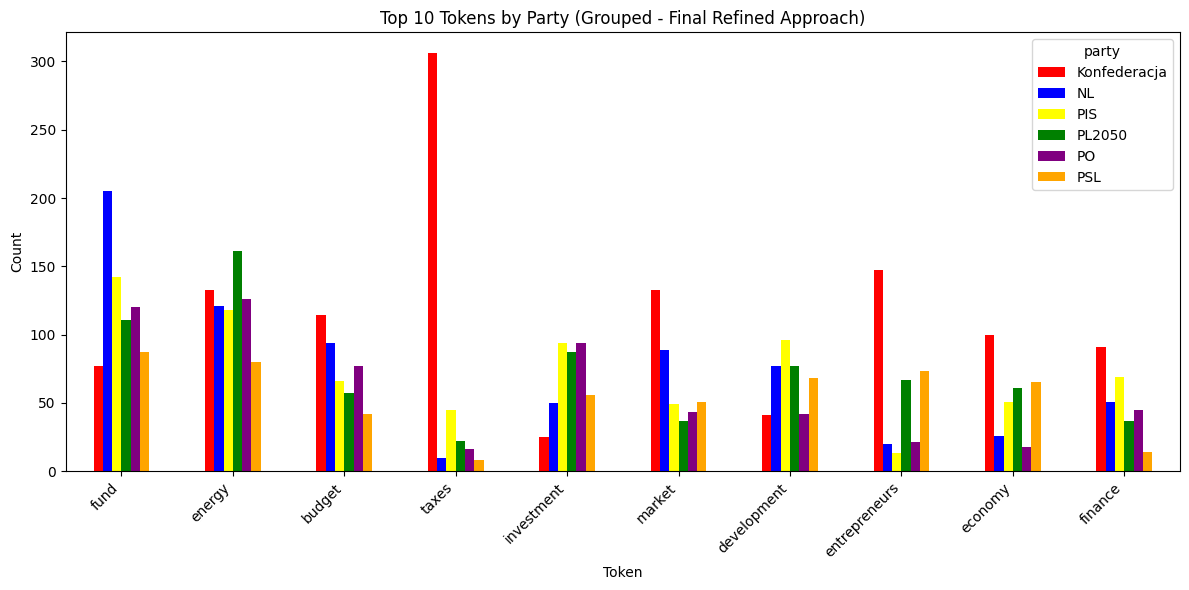

<Figure size 640x480 with 0 Axes>

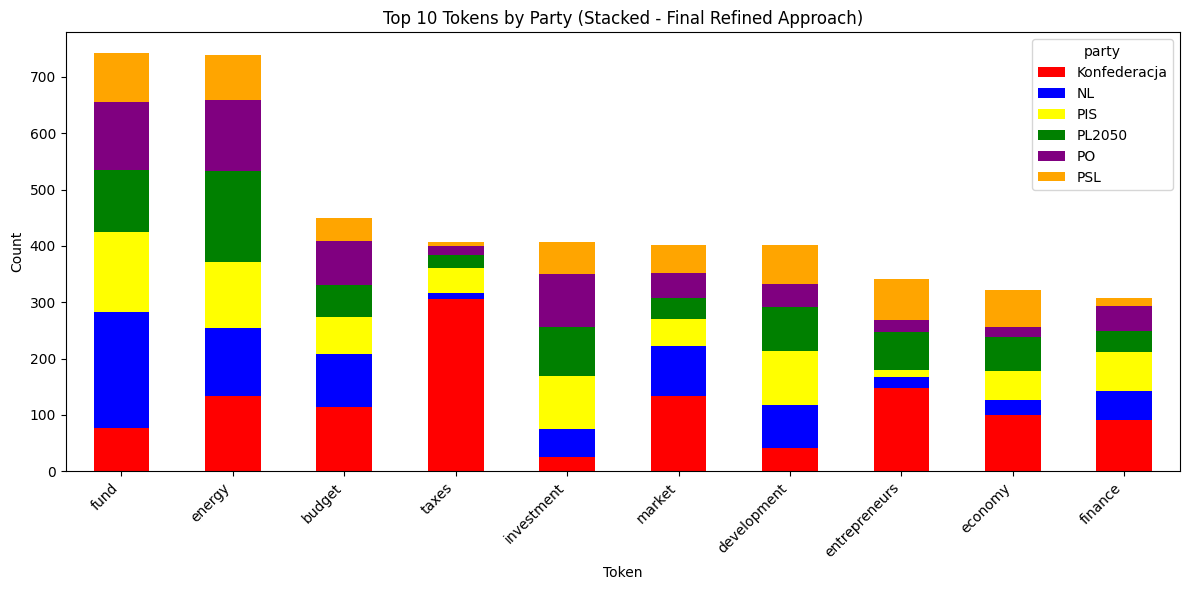


Plotting Share for: Final_Refined Method


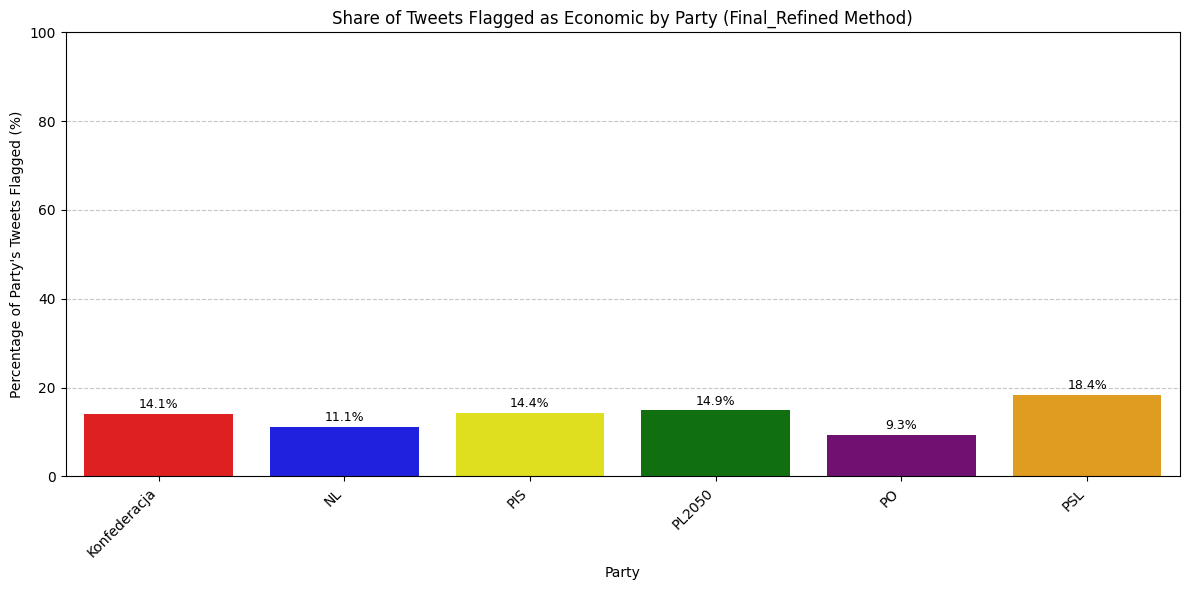

------------------------------------------------------------

----> Party-Level Analysis Complete <----


In [35]:
# ==============================================================================
# 8. PARTY-LEVEL ANALYSIS & VISUALIZATION
# ==============================================================================
# This section defines functions and performs analysis on token usage and
# flagging shares broken down by political party, using specified party colors.
# Analysis for each method is called sequentially.

# Only run if party column exists and run_party_analysis is True (set in Section 7)
if run_party_analysis:
    print("\n--- 8. Party-Level Analysis & Visualization (7D Structure) ---")

    # --- Configuration ---
    # party_col defined in Section 7
    # party_colors defined in Section 7
    top_n_party_tokens = 10


    # --------------------------------------------------------------------------
    # 8.A: Define Helper Functions
    # --------------------------------------------------------------------------
    # (Includes get_party_token_counts, plot_party_top_tokens (modified for color),
    #  and plot_party_share from previous responses)

    def get_party_token_counts(df, token_col='union_tokens', party_col='party'):
        """ Counts tokens per party from a specified column. """
        if token_col not in df.columns or party_col not in df.columns:
            print(f"Warning: Missing cols ('{token_col}' or '{party_col}') in get_party_token_counts. Returning empty DF.")
            return pd.DataFrame([], columns=[party_col, 'token', 'count'])
        party_token_map = defaultdict(Counter)
        for idx, row in df.iterrows():
            party = row.get(party_col, 'Unknown_Party')
            tokens = row.get(token_col, [])
            if isinstance(tokens, list):
                for token in tokens: party_token_map[party][token] += 1
        records = [(p, t, c) for p, counter in party_token_map.items() for t, c in counter.items()]
        return pd.DataFrame(records, columns=[party_col, 'token', 'count'])

    def plot_party_top_tokens(df_party, party_colors_dict, top_n=10, approach="Unknown", party_col='party'):
        """ Plots grouped and stacked bar charts for top N tokens, colored by party using provided dict. """
        if df_party.empty or not all(c in df_party.columns for c in [party_col, 'token', 'count']):
            print(f"Info: Input DataFrame for plot_party_top_tokens ('{approach}') is empty or missing columns. Skipping plots.")
            return pd.DataFrame() # Return empty if nothing to plot
        token_totals = df_party.groupby('token')['count'].sum()
        if token_totals.empty: print(f"Info: No token counts to plot for plot_party_top_tokens ('{approach}'). Skipping plots."); return pd.DataFrame()
        top_tokens = token_totals.sort_values(ascending=False).head(top_n).index.tolist()
        df_top = df_party[df_party['token'].isin(top_tokens)]
        if df_top.empty: print(f"Info: No data for top {top_n} tokens ('{approach}'). Skipping plots."); return pd.DataFrame()
        try: pivot = pd.pivot_table(df_top, index='token', columns=party_col, values='count', fill_value=0, aggfunc='sum')
        except Exception as e: print(f"Warning: Pivot table failed ('{approach}'): {e}. Skipping plots."); return pd.DataFrame()
        for party in party_colors_dict:
            if party != 'Unknown_Party' and party not in pivot.columns: pivot[party] = 0
        pivot['total'] = pivot.sum(axis=1); pivot = pivot.sort_values('total', ascending=False).drop(columns='total')
        if pivot.empty: print(f"Info: Pivot table empty after sorting ('{approach}'). Skipping plots."); return pivot

        print(f"\nPlotting top {top_n} tokens by party for approach: {approach}")
        plot_colors = [party_colors_dict.get(party, party_colors_dict.get('Unknown_Party','grey')) for party in pivot.columns]
        # Grouped Bar Chart
        try:
            plt.figure(); ax_grouped = pivot.plot(kind='bar', figsize=(12,6), color=plot_colors)
            ax_grouped.set_title(f"Top {top_n} Tokens by Party (Grouped - {approach} Approach)"); ax_grouped.set_xlabel("Token"); ax_grouped.set_ylabel("Count")
            ax_grouped.legend(title=party_col); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()
        except Exception as e: print(f"Error plotting grouped bar for {approach}: {e}")
        # Stacked Bar Chart
        try:
            plt.figure(); ax_stacked = pivot.plot(kind='bar', stacked=True, figsize=(12,6), color=plot_colors)
            ax_stacked.set_title(f"Top {top_n} Tokens by Party (Stacked - {approach} Approach)"); ax_stacked.set_xlabel("Token"); ax_stacked.set_ylabel("Count")
            ax_stacked.legend(title=party_col); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()
        except Exception as e: print(f"Error plotting stacked bar for {approach}: {e}")
        return pivot

    def plot_party_share(party_summary_df, method_name, share_col_name, party_colors_dict, party_col='party'):
        """ Plots a single bar chart for party shares for one method, colored by party. """
        print(f"\nPlotting Share for: {method_name} Method")
        if party_summary_df.empty or share_col_name not in party_summary_df.columns:
            print(f"Skipping share plot for {method_name}: Summary data or column '{share_col_name}' missing.")
            return
        if not isinstance(party_colors_dict, dict):
            print(f"Skipping share plot for {method_name}: party_colors_dict is not a dictionary."); return

        plt.figure(figsize=(12, 6))
        plot_palette = [party_colors_dict.get(party, party_colors_dict.get('Unknown_Party', 'grey')) for party in party_summary_df[party_col]]
        ax = sns.barplot(x=party_col, y=share_col_name, data=party_summary_df, palette=plot_palette, hue=party_col, legend=False)
        plt.title(f'Share of Tweets Flagged as Economic by Party ({method_name} Method)')
        plt.xlabel("Party"); plt.ylabel("Percentage of Party's Tweets Flagged (%)")
        plt.xticks(rotation=45, ha='right'); plt.grid(axis='y', linestyle='--', alpha=0.7)
        for container in ax.containers: ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=2, fontsize=9)
        plt.ylim(0, max(100, party_summary_df[share_col_name].max() * 1.1)); plt.tight_layout(); plt.show()

    print("Party analysis helper functions defined.")
    print("-" * 50)


    # --------------------------------------------------------------------------
    # 8.B: Calculate Party Summary Statistics (Shares) - Run Once
    # --------------------------------------------------------------------------
    # (Keep this section exactly as in the previous response to calculate party_summary)
    print("\n--- 8.B: Calculating Party Summary Statistics (Counts & Shares %) ---")
    flag_cols_share = {
        'Union': 'union_flag', 'Gateway': 'gateway_flag', 'Final_Refined': 'has_econ_term_FILTERED'}
    required_flags = list(flag_cols_share.values())
    missing_share_flags = [col for col in required_flags if col not in df_clean_translated.columns]
    party_summary = pd.DataFrame() # Initialize
    if party_col not in df_clean_translated.columns: print(f"ERROR: Party column '{party_col}' missing.")
    elif missing_share_flags: print(f"ERROR: Flag columns missing for share analysis: {missing_share_flags}.")
    elif 'party_colors' not in locals(): print("ERROR: 'party_colors' not defined.")
    else:
        try:
            party_summary = df_clean_translated.groupby(party_col).agg(
                total_tweets=pd.NamedAgg(column=party_col, aggfunc='size'),
                **{f'{name}_count': pd.NamedAgg(column=flag_col, aggfunc='sum')
                for name, flag_col in flag_cols_share.items()}).reset_index()
            for name in flag_cols_share.keys():
                count_col=f'{name}_count'; share_col=f'{name}_share_pct'
                party_summary[share_col] = party_summary.apply(lambda r: (r[count_col]/r['total_tweets']*100) if r['total_tweets'] > 0 else 0, axis=1)
            print("\nParty Summary Table (Counts and Shares %):")
            party_summary = party_summary.sort_values(by=party_col)
            try: display(party_summary.round(2))
            except NameError: print(party_summary.round(2).to_string())
        except Exception as e: print(f"An error occurred during share calculation: {e}"); party_summary = pd.DataFrame()
    print("-" * 60)


    # --------------------------------------------------------------------------
    # 8.C: Generate Plots and Analysis (Method by Method)
    # --------------------------------------------------------------------------
    # This block follows the structure you requested, making it easier to comment out methods.

    # # --- Union Approach ---
    # # To skip Union analysis, comment out from the line below down to the next section
    # print("\n--- Running Analysis for: Union Method ---")
    # union_token_col = 'union_tokens'
    # union_share_col = 'Union_share_pct'
    # if union_token_col in df_clean_translated.columns:
    #     df_party_union = get_party_token_counts(df_clean_translated, token_col=union_token_col, party_col=party_col)
    #     pivot_union = plot_party_top_tokens(df_party_union, party_colors, top_n=top_n_party_tokens, approach="Union", party_col=party_col)
    #     plot_party_share(party_summary, 'Union', union_share_col, party_colors, party_col)
    # else: print(f"Skipping Union analysis: Column '{union_token_col}' not found.")
    # print("-" * 30) # End of Union block


    # # --- Gateway Approach ---
    # # To skip Gateway analysis, comment out from the line below down to the next section
    # print("\n--- Running Analysis for: Gateway Method ---")
    # gateway_token_col = 'gateway_tokens'
    # gateway_share_col = 'Gateway_share_pct'
    # if gateway_token_col in df_clean_translated.columns:
    #     df_party_gateway = get_party_token_counts(df_clean_translated, token_col=gateway_token_col, party_col=party_col)
    #     pivot_gateway = plot_party_top_tokens(df_party_gateway, party_colors, top_n=top_n_party_tokens, approach="Gateway", party_col=party_col)
    #     plot_party_share(party_summary, 'Gateway', gateway_share_col, party_colors, party_col)
    # else: print(f"Skipping Gateway analysis: Column '{gateway_token_col}' not found.")
    # print("-" * 30) # End of Gateway block


    # --- Final Refined Approach ---
    # To skip Final Refined analysis, comment out from the line below down to the next section -> for now will leave this part only as it is the one needed
    print("\n--- Running Analysis for: Final Refined Method ---")
    final_kw_col_party = 'matched_keywords_FILTERED' # Use final keywords column
    final_share_col = 'Final_Refined_share_pct'
    if final_kw_col_party in df_clean_translated.columns:
        df_party_final = get_party_token_counts(df_clean_translated, token_col=final_kw_col_party, party_col=party_col)
        pivot_final = plot_party_top_tokens(df_party_final, party_colors, top_n=top_n_party_tokens, approach="Final Refined", party_col=party_col)
        plot_party_share(party_summary, 'Final_Refined', final_share_col, party_colors, party_col)
    else: print(f"Skipping Final Refined analysis: Column '{final_kw_col_party}' not found.")
    print("-" * 60) # End of Final Refined block


# Final completion message for the whole section
if run_party_analysis:
    print("\n" + "="*60)
    print("----> Party-Level Analysis Complete <----")
    print("="*60)

In [37]:
# # --------------------------------------------------------------------------
# # 8.F: Display Detailed Token Counts per Party for Selected Methods
# # --------------------------------------------------------------------------
# # This block calculates and displays the full, sorted list of tokens and
# # their counts for each party, but only for the methods specified in the list below.

# # !!! --- CONTROL WHICH METHODS TO DISPLAY DETAILS FOR --- !!!

# # List includes 'Union', 'Gateway', and/or 'Final_Refined'
# methods_to_display_details = ['Final_Refined'] #['Union', 'Gateway', 'Final_Refined']
# # Example: methods_to_display_details = ['Final_Refined'] # Only show details for the final method
# # Example: methods_to_display_details = [] # Skip this detailed display section
# print(f"\n--- 8.F: Displaying Detailed Token Counts per Party for: {', '.join(methods_to_display_details)} ---")
# # Define mapping from method name to token column
# method_to_token_col = {
#     'Union': 'union_tokens',
#     'Gateway': 'gateway_tokens',
#     'Final_Refined': 'matched_keywords_FILTERED'
# }
# if not run_party_analysis:
#     print("Skipping detailed display because party analysis did not run.")
# elif not methods_to_display_details:
#      print("Skipping detailed display because 'methods_to_display_details' list is empty.")
# else:
#     # Loop through the methods requested by the user
#     for method_name in methods_to_display_details:
#         print("\n" + "="*20 + f" Method: {method_name} " + "="*20)
#         token_col = method_to_token_col.get(method_name)
#         if not token_col:
#             print(f"ERROR: Unknown method name '{method_name}' in control list.")
#             continue
#         if token_col not in df_clean_translated.columns:
#             print(f"ERROR: Token column '{token_col}' not found for method '{method_name}'. Cannot display details.")
#             continue
#         # Calculate the party-token counts for this method
#         # (Recalculates, independent of whether plots in 8.C/D/E ran)
#         df_party_current = get_party_token_counts(df_clean_translated, token_col=token_col, party_col=party_col)
#         if df_party_current.empty:
#             print(f"No token counts found for method '{method_name}'.")
#             continue
#         # Get unique parties present for this method's results
#         unique_parties = sorted(df_party_current[party_col].unique())
#         print(f"Displaying token counts for {len(unique_parties)} parties found with tokens for this method:")
#         # Display sorted table for each party
#         for party in unique_parties:
#             print(f"\n--- Party: {party} ({method_name} Tokens) ---")
#             party_df = df_party_current[df_party_current[party_col] == party].sort_values('count', ascending=False)
#             if party_df.empty:
#                 print("(No tokens found for this party in this method's results)")
#                 continue
#             # Set display options to show more rows for detailed view
#             original_max_rows = pd.get_option('display.max_rows')
#             pd.set_option('display.max_rows', len(party_df) + 10) # Show all rows for this party
#             try:
#                 # Display the filtered and sorted DataFrame for the party
#                 display(party_df[['token', 'count']]) # Display only token and count
#             except NameError:
#                 # Fallback for non-notebook environments
#                 print(party_df[['token', 'count']].to_string(index=False))
#             finally:
#                 # Reset display options
#                 pd.set_option('display.max_rows', original_max_rows)
# # Fnal completion message for the whole section (keep outside the loop)
# if run_party_analysis:
#     print("\n" + "="*60)
#     print("--- Party-Level Analysis Complete ---")
#     print("="*60)

#### 1. Most economic tweets (by party and by user)


--- 9. Top People Posting Analysis ---
Helper functions defined for Top People analysis.
------------------------------------------------------------

--- 9.B.3: Top People Analysis - Final Refined Approach ---
Top 10 People Posting (Final Refined Approach, by total tweets per party):


,party,name,total_tweets,econ_tweets,econ_pct
0,Konfederacja,Bartłomiej Pejo,1546,301,19.469599
3,Konfederacja,Konrad Berkowicz,1538,172,11.183355
5,Konfederacja,Marcin Sypniewski,1520,257,16.907895
8,Konfederacja,Sławomir Mentzen,1489,264,17.730020
10,Konfederacja,Włodzimierz Skalik,1465,164,11.194539
2,Konfederacja,Grzegorz Płaczek,1315,158,12.015209
9,Konfederacja,Witold Tumanowicz,1262,164,12.995246
1,Konfederacja,Grzegorz Braun,776,26,3.350515
6,Konfederacja,Michał Wawer,696,154,22.126437
4,Konfederacja,Krzysztof Tuduj,384,30,7.812500



Generating Top People plots (Sorted Within Party) for: Final Refined Approach


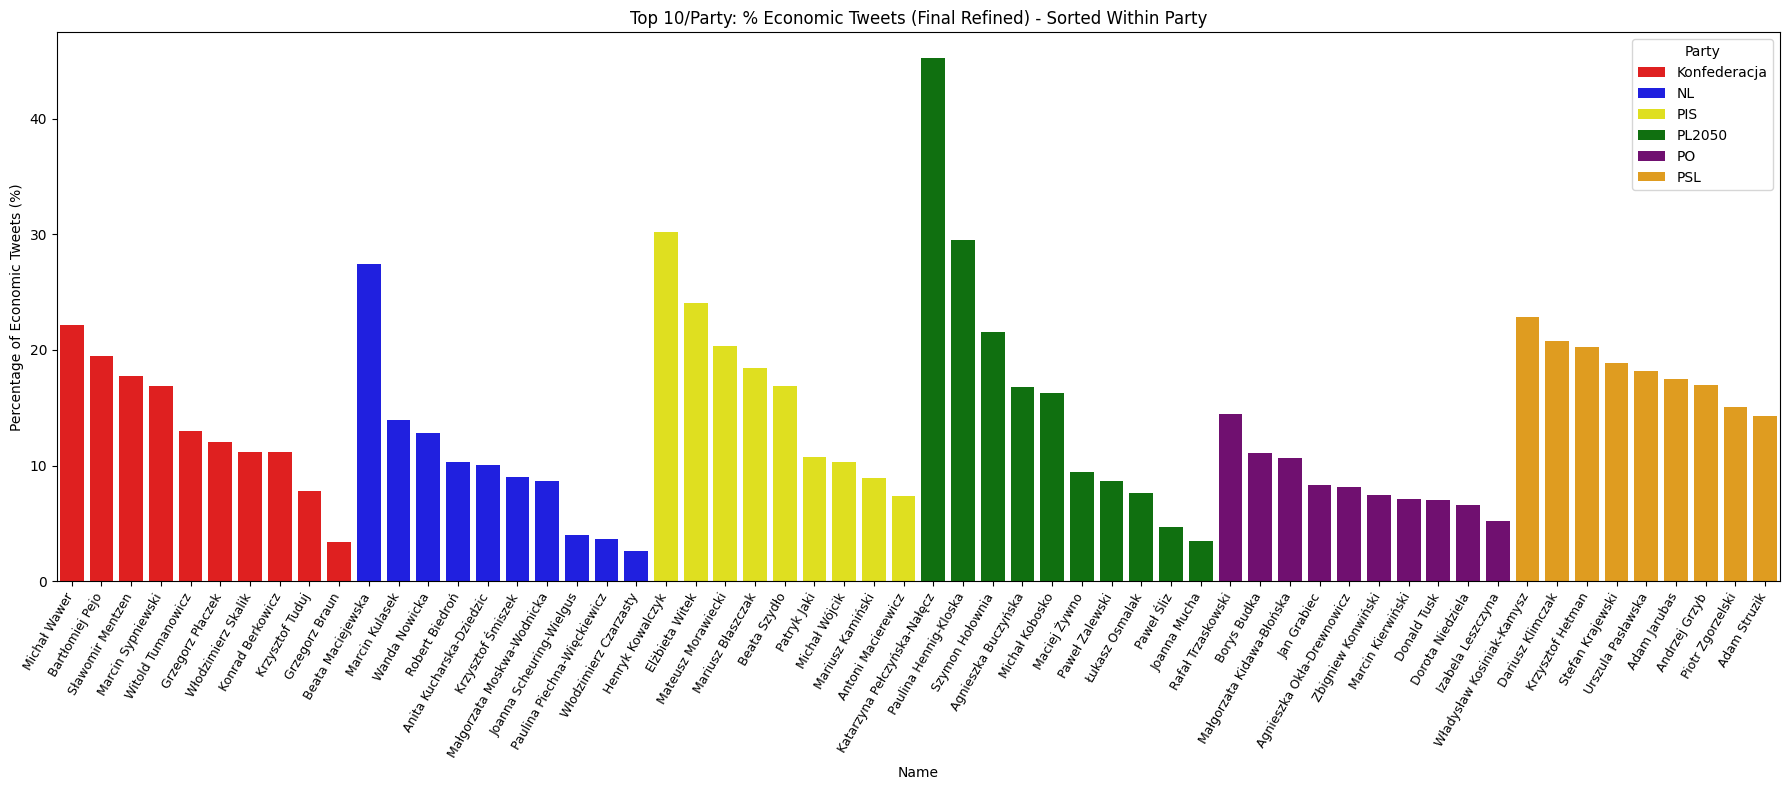

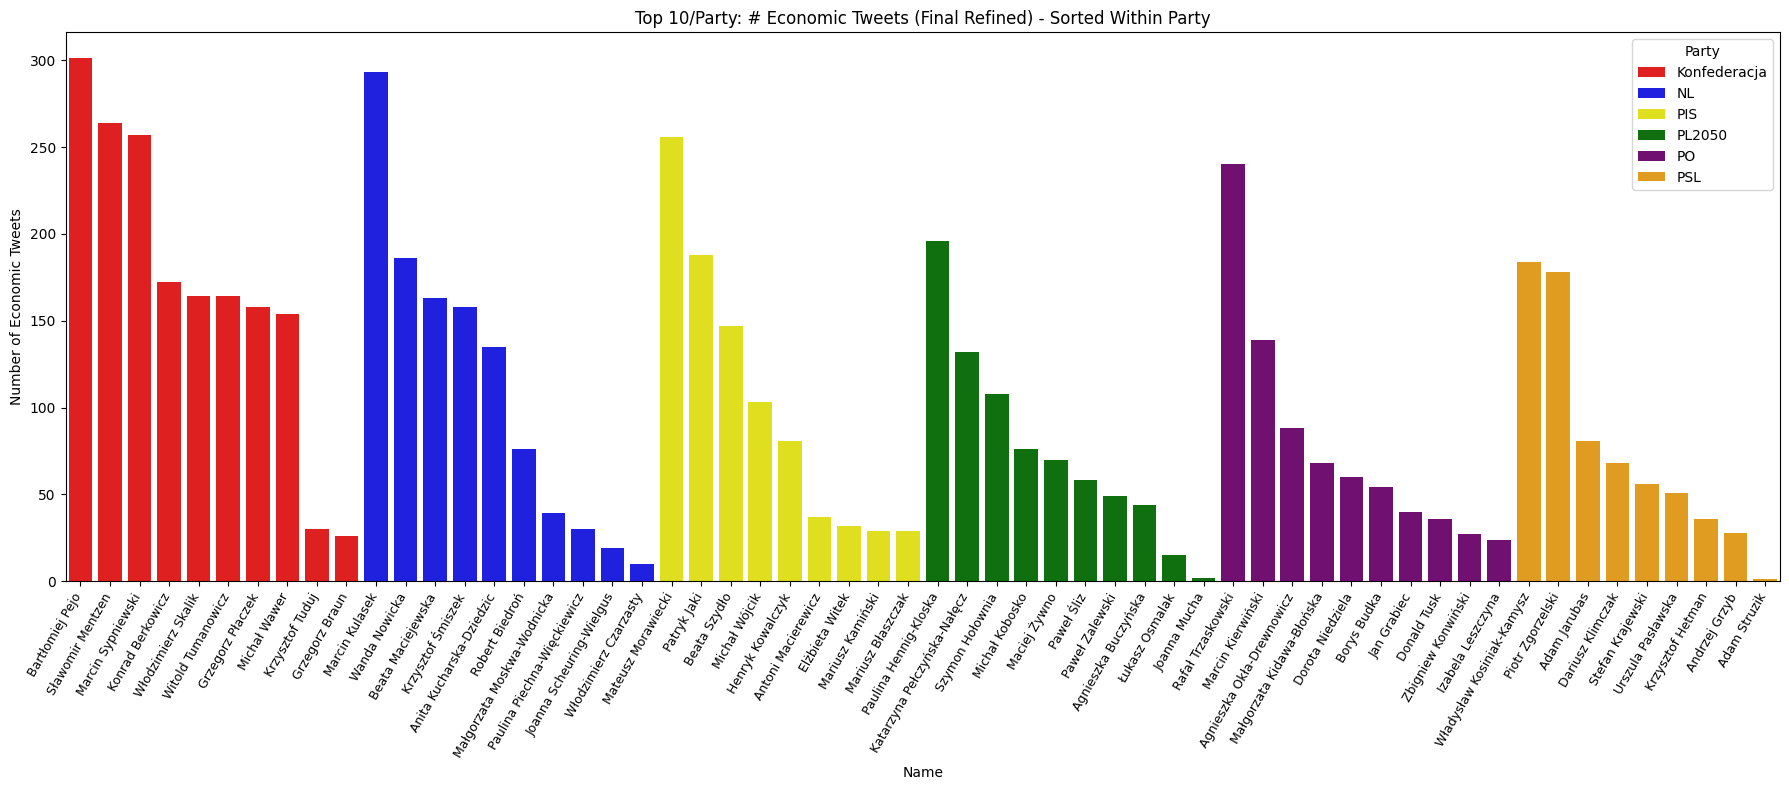

------------------------------

--- 9.C: Overall Top People Plots (Final Refined Method - Sorted Globally) ---
Generating overall plots based on the 58 users identified from Final Refined method...


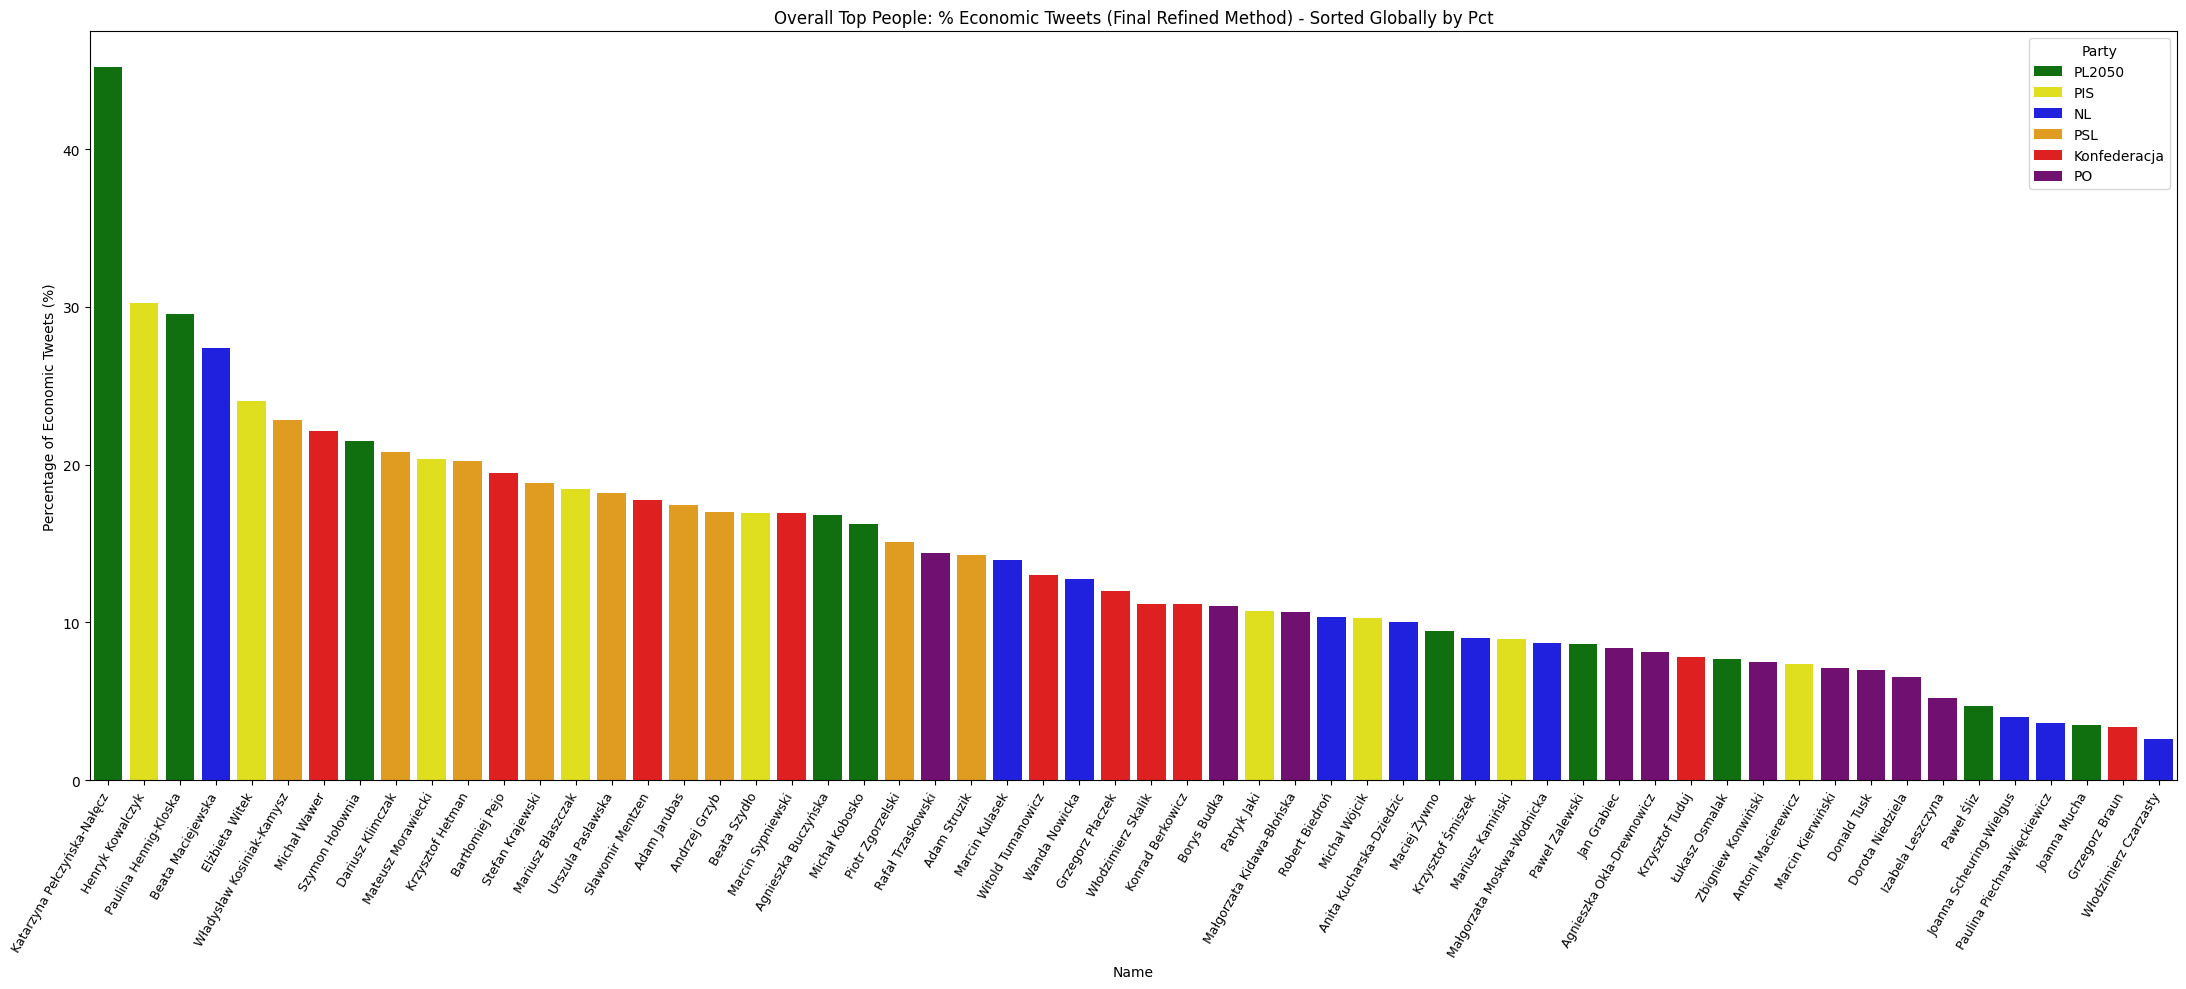

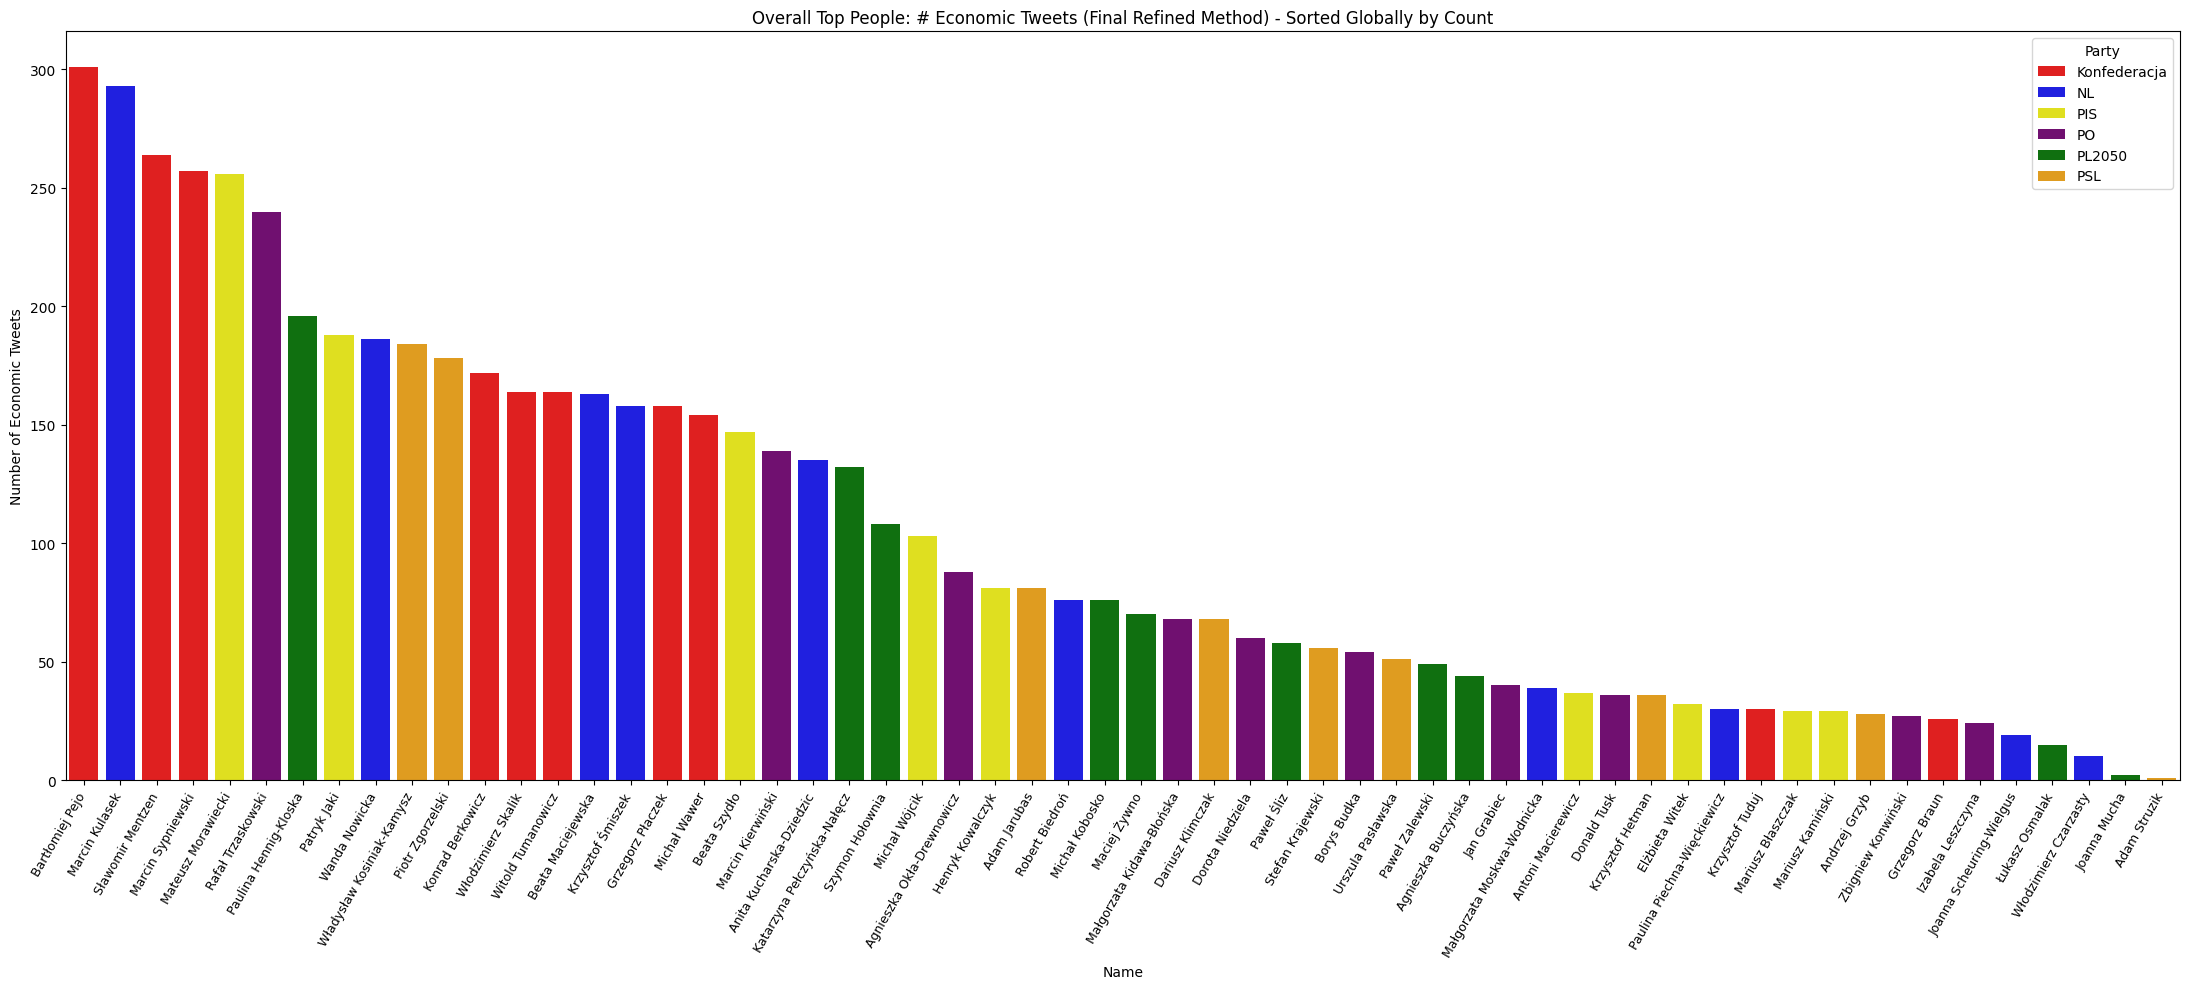


--- Top People Analysis Section Complete ---


In [38]:
# ==============================================================================
# 9. TOP PEOPLE POSTING ANALYSIS (Per Method & Overall)
# ==============================================================================
# This section analyzes which users post the most overall and the most economic tweets, broken down by party and method, using specified party colors.
# Plots show users sorted WITHIN party for each method, and then plots sorted OVERALL for the Final Refined method.

# Import necessary for transforms
import matplotlib.transforms as mtransforms

# Only run if party analysis is generally enabled (set in Section 7)
# and top people analysis is runnable (checks for user_col and party_colors)
if 'run_party_analysis' in locals() and run_party_analysis:
    print("\n--- 9. Top People Posting Analysis ---")

    # --- Configuration ---
    # party_col should be defined in Section 7 (e.g., party_col = 'party')
    # party_colors should be defined in Section 7
    user_col = 'name' # !!! CHECK IF NAME OF THE VARIABLE IS CORRECT !!!
    top_n_people = 10 # Number of top people per party to analyze

    # Check required columns for the section
    if user_col not in df_clean_translated.columns:
         print(f"ERROR: User column '{user_col}' not found. Skipping Top People Analysis.")
         run_top_people_analysis = False
    elif 'party_colors' not in locals() or not isinstance(party_colors, dict): # Ensure party_colors is a dict
         print("ERROR: 'party_colors' dictionary not found or not a dictionary. Skipping Top People Analysis.")
         run_top_people_analysis = False
    else:
         run_top_people_analysis = True # Set to True if checks pass

# Only proceed if columns exist AND initial party analysis was set to run
if 'run_party_analysis' in locals() and run_party_analysis and 'run_top_people_analysis' in locals() and run_top_people_analysis:


    # --------------------------------------------------------------------------
    # 9.A: Define Helper Functions
    # --------------------------------------------------------------------------
# (Located in Section 9.A: Define Helper Functions)

    def top_people_economic_party(df, user_col='name', party_col='party', econ_flag_col='union_flag', top_n=10):
        """ Calculates top N posters per party based on total tweets and their economic tweet stats. """

        if not all(c in df.columns for c in [user_col, party_col, econ_flag_col]):
            print(f"Warning: Missing columns in top_people_economic_party ({user_col}, {party_col}, {econ_flag_col}). Returning empty DF.")
            return pd.DataFrame([], columns=[party_col, user_col, 'total_tweets', 'econ_tweets', 'econ_pct'])

        # Calculate total tweets per user and party
        total_tweets = df.groupby([party_col, user_col]).size().rename("total_tweets")

        # Calculate economic tweets per user and party
        # Ensure econ_flag_col is boolean for correct filtering and sum
        econ_tweets = df[df[econ_flag_col].astype(bool)].groupby([party_col, user_col]).size().rename("econ_tweets")

        # Combine into a single DataFrame
        df_users = pd.concat([total_tweets, econ_tweets], axis=1).fillna(0) # Fill NaN econ_tweets with 0
        df_users['econ_tweets'] = df_users['econ_tweets'].astype(int) # Ensure integer counts

        # Calculate percentage of economic tweets for each user
        # Replace potential 0 in total_tweets with NaN to avoid division by zero, then fill resulting NaN with 0
        df_users['econ_pct'] = (df_users['econ_tweets'] / df_users['total_tweets'].replace(0, np.nan) * 100).fillna(0)
        
        df_users = df_users.reset_index() # 'party' and 'user_col' are now guaranteed columns

        # --- Get top N users per party based on *total* tweets ---
        # This pattern is generally more robust for getting top N per group while keeping group keys as columns.
        top_users = (df_users.sort_values(["total_tweets"], ascending=[False])
                    .groupby(party_col, group_keys=False)
                    .head(top_n))

        # Final sort for presentation
        return top_users.sort_values([party_col, 'total_tweets'], ascending=[True, False])


    def plot_top_people_by_party_sorted(top_users_df, party_colors_dict, method_name, top_n=10, user_col='name', party_col='party', figsize=(18, 8), x_label_rotation=60, x_label_ha='right', x_offset_points=0):
        """ Plots % and # of economic tweets for top users, sorted WITHIN party, colored by party. """
        if top_users_df.empty: print(f"Info: Empty DataFrame for plot_top_people_by_party_sorted ('{method_name}'). Skipping."); return
        if not all(c in top_users_df.columns for c in [party_col, user_col, 'econ_pct', 'econ_tweets']): print(f"Warning: Missing columns in plot_top_people_by_party_sorted ('{method_name}'). Skipping."); return
        if not isinstance(party_colors_dict, dict): print(f"Warning: Invalid party_colors_dict ('{method_name}'). Skipping."); return

        print(f"\nGenerating Top People plots (Sorted Within Party) for: {method_name} Approach")
        
        # --- Plot 1: Percentage (Sorted within Party) ---
        try:
            top_users_sorted_pct = top_users_df.sort_values(by=[party_col, 'econ_pct'], ascending=[True, False])
            fig1, ax1 = plt.subplots(figsize=figsize)
            sns.barplot(data=top_users_sorted_pct, x=user_col, y='econ_pct', hue=party_col,
                        palette=party_colors_dict, dodge=False, ax=ax1)
            ax1.set_title(f"Top {top_n}/Party: % Economic Tweets ({method_name}) - Sorted Within Party")
            ax1.set_xlabel(user_col.capitalize()); ax1.set_ylabel("Percentage of Economic Tweets (%)")
            
            ax1.set_xticks(ax1.get_xticks()) # Mitigate UserWarning
            ax1.set_xticklabels(ax1.get_xticklabels(), rotation=x_label_rotation, ha=x_label_ha, fontsize=9)
            if x_offset_points != 0:
                dx = x_offset_points / 72.; dy = 0.
                offset = mtransforms.ScaledTranslation(dx, dy, fig1.dpi_scale_trans)
                for label in ax1.xaxis.get_majorticklabels():
                    label.set_transform(label.get_transform() + offset)
            
            ax1.legend(title=party_col.capitalize(), loc='upper right'); # Legend inside
            plt.tight_layout(); plt.show()
        except Exception as e: print(f"Error plotting percentage chart for {method_name}: {e}")

        # --- Plot 2: Count (Sorted within Party) ---
        try:
            top_users_sorted_count = top_users_df.sort_values(by=[party_col, 'econ_tweets'], ascending=[True, False])
            fig2, ax2 = plt.subplots(figsize=figsize)
            sns.barplot(data=top_users_sorted_count, x=user_col, y='econ_tweets', hue=party_col,
                        palette=party_colors_dict, dodge=False, ax=ax2)
            ax2.set_title(f"Top {top_n}/Party: # Economic Tweets ({method_name}) - Sorted Within Party")
            ax2.set_xlabel(user_col.capitalize()); ax2.set_ylabel("Number of Economic Tweets")

            ax2.set_xticks(ax2.get_xticks()) # Mitigate UserWarning
            ax2.set_xticklabels(ax2.get_xticklabels(), rotation=x_label_rotation, ha=x_label_ha, fontsize=9)
            if x_offset_points != 0:
                dx = x_offset_points / 72.; dy = 0.
                offset = mtransforms.ScaledTranslation(dx, dy, fig2.dpi_scale_trans)
                for label in ax2.xaxis.get_majorticklabels():
                    label.set_transform(label.get_transform() + offset)

            ax2.legend(title=party_col.capitalize(), loc='upper right'); # Legend inside
            plt.tight_layout(); plt.show()
        except Exception as e: print(f"Error plotting count chart for {method_name}: {e}")

    print("Helper functions defined for Top People analysis.")
    print("-" * 60)


    # --------------------------------------------------------------------------
    # 9.B: Generate Top People Data & Party-Sorted Plots (Method by Method)
    # --------------------------------------------------------------------------
    # --- Define x-axis label parameters for party-sorted plots ---
    PARTY_SORTED_X_ROTATION = 60
    PARTY_SORTED_X_HA = 'right'  # 'center' or 'right'
    PARTY_SORTED_X_OFFSET = 3    # Points to shift right (positive) or left (negative)

    top_people_union = pd.DataFrame() # Initialize to avoid NameError if a block is skipped
    top_people_gateway = pd.DataFrame()
    top_people_final = pd.DataFrame()


    # # --- Union Approach ---
    # # Comment it comment out this block if not needed
    # print("\n--- 9.B.1: Top People Analysis - Union Approach ---")
    # union_flag_col = 'union_flag'
    # if union_flag_col in df_clean_translated.columns:
    #     top_people_union = top_people_economic_party(
    #         df_clean_translated, user_col=user_col, party_col=party_col,
    #         econ_flag_col=union_flag_col, top_n=top_n_people)
    #     print(f"Top {top_n_people} People Posting (Union Approach, by total tweets per party):")
    #     try: display(top_people_union)
    #     except NameError: print(top_people_union.to_string())
    #     if not top_people_union.empty : # Only plot if data exists
    #          plot_top_people_by_party_sorted(
    #              top_people_union, party_colors, "Union", top_n=top_n_people,
    #              user_col=user_col, party_col=party_col,
    #              x_label_rotation=PARTY_SORTED_X_ROTATION, x_label_ha=PARTY_SORTED_X_HA, x_offset_points=PARTY_SORTED_X_OFFSET)
    # else: print(f"Skipping Union Top People analysis: Flag column '{union_flag_col}' not found.")
    # print("-" * 60)
    # ###---### End Union ---###


    # # --- Gateway Approach ---
    # # Comment it out this block if not needed
    # print("\n--- 9.B.2: Top People Analysis - Gateway Approach ---")
    # gateway_flag_col = 'gateway_flag'
    # if gateway_flag_col in df_clean_translated.columns:
    #     top_people_gateway = top_people_economic_party(
    #         df_clean_translated, user_col=user_col, party_col=party_col,
    #         econ_flag_col=gateway_flag_col, top_n=top_n_people)
    #     print(f"Top {top_n_people} People Posting (Gateway Approach, by total tweets per party):")
    #     try: display(top_people_gateway)
    #     except NameError: print(top_people_gateway.to_string())
    #     if not top_people_gateway.empty: # Only plot if data exists
    #         plot_top_people_by_party_sorted(
    #             top_people_gateway, party_colors, "Gateway", top_n=top_n_people,
    #             user_col=user_col, party_col=party_col,
    #             x_label_rotation=PARTY_SORTED_X_ROTATION, x_label_ha=PARTY_SORTED_X_HA, x_offset_points=PARTY_SORTED_X_OFFSET)
    # else: print(f"Skipping Gateway Top People analysis: Flag column '{gateway_flag_col}' not found.")
    # print("-" * 60)
    # ###---### End Gateway ---###


    # --- Final Refined Approach ---
    # You can comment out this block if not needed
    print("\n--- 9.B.3: Top People Analysis - Final Refined Approach ---")
    final_flag_col_tp = 'has_econ_term_FILTERED' # Use final flag name
    if final_flag_col_tp in df_clean_translated.columns:
        top_people_final = top_people_economic_party(
            df_clean_translated, user_col=user_col, party_col=party_col,
            econ_flag_col=final_flag_col_tp, top_n=top_n_people)
        print(f"Top {top_n_people} People Posting (Final Refined Approach, by total tweets per party):")
        try: display(top_people_final)
        except NameError: print(top_people_final.to_string())
        if not top_people_final.empty: # Only plot if data exists
            plot_top_people_by_party_sorted(
                top_people_final, party_colors, "Final Refined", top_n=top_n_people,
                user_col=user_col, party_col=party_col,
                x_label_rotation=PARTY_SORTED_X_ROTATION, x_label_ha=PARTY_SORTED_X_HA, x_offset_points=PARTY_SORTED_X_OFFSET)
    else: print(f"Skipping Final Refined Top People analysis: Flag column '{final_flag_col_tp}' not found.")
    print("-" * 30)
    ###---### End Final Refined ---###


    # --------------------------------------------------------------------------
    # 9.C: Overall Top People Plots (Final Refined Method - Sorted Globally)
    # --------------------------------------------------------------------------
    print("\n--- 9.C: Overall Top People Plots (Final Refined Method - Sorted Globally) ---")

    # Define x-axis label parameters for these overall plots
    OVERALL_X_ROTATION = 60
    OVERALL_X_HA = 'right'
    OVERALL_X_OFFSET = 3 # Adjust as needed

    if 'top_people_final' not in locals() or top_people_final.empty:
        print("Skipping overall plots: 'top_people_final' DataFrame is empty or not created (likely its source method was skipped or had no data).")
    else:
        print(f"Generating overall plots based on the {len(top_people_final)} users identified from Final Refined method...")
        overall_figsize = (22, 10) # Wider for more names

        # --- Plot 1: Overall Percentage (Sorted Globally) ---
        try:
            overall_sorted_pct = top_people_final.sort_values(by="econ_pct", ascending=False)
            overall_order_pct = overall_sorted_pct[user_col].tolist()
            fig_ov_pct, ax_ov_pct = plt.subplots(figsize=overall_figsize)
            sns.barplot(data=overall_sorted_pct, x=user_col, y='econ_pct', hue=party_col,
                        order=overall_order_pct, palette=party_colors, dodge=False, ax=ax_ov_pct)
            ax_ov_pct.set_title(f"Overall Top People: % Economic Tweets (Final Refined Method) - Sorted Globally by Pct")
            ax_ov_pct.set_xlabel(user_col.capitalize()); ax_ov_pct.set_ylabel("Percentage of Economic Tweets (%)")
            ax_ov_pct.set_xticks(ax_ov_pct.get_xticks())
            ax_ov_pct.set_xticklabels(ax_ov_pct.get_xticklabels(), rotation=OVERALL_X_ROTATION, ha=OVERALL_X_HA, fontsize=9)
            if OVERALL_X_OFFSET != 0:
                dx = OVERALL_X_OFFSET / 72.; dy = 0.
                offset = mtransforms.ScaledTranslation(dx, dy, fig_ov_pct.dpi_scale_trans)
                for label in ax_ov_pct.xaxis.get_majorticklabels():
                    label.set_transform(label.get_transform() + offset)
            ax_ov_pct.legend(title=party_col.capitalize(), loc='upper right');
            plt.tight_layout(); plt.show()
        except Exception as e: print(f"Error plotting overall percentage chart: {e}")

        # --- Plot 2: Overall Count (Sorted Globally) ---
        try:
            overall_sorted_count = top_people_final.sort_values(by="econ_tweets", ascending=False)
            overall_order_count = overall_sorted_count[user_col].tolist()
            fig_ov_count, ax_ov_count = plt.subplots(figsize=overall_figsize)
            sns.barplot(data=overall_sorted_count, x=user_col, y='econ_tweets', hue=party_col,
                        order=overall_order_count, palette=party_colors, dodge=False, ax=ax_ov_count)
            ax_ov_count.set_title(f"Overall Top People: # Economic Tweets (Final Refined Method) - Sorted Globally by Count")
            ax_ov_count.set_xlabel(user_col.capitalize()); ax_ov_count.set_ylabel("Number of Economic Tweets")
            ax_ov_count.set_xticks(ax_ov_count.get_xticks())
            ax_ov_count.set_xticklabels(ax_ov_count.get_xticklabels(), rotation=OVERALL_X_ROTATION, ha=OVERALL_X_HA, fontsize=9)
            if OVERALL_X_OFFSET != 0:
                dx = OVERALL_X_OFFSET / 72.; dy = 0.
                offset = mtransforms.ScaledTranslation(dx, dy, fig_ov_count.dpi_scale_trans)
                for label in ax_ov_count.xaxis.get_majorticklabels():
                    label.set_transform(label.get_transform() + offset)
            ax_ov_count.legend(title=party_col.capitalize(), loc='upper right');
            plt.tight_layout(); plt.show()
        except Exception as e: print(f"Error plotting overall count chart: {e}")

# Final completion message
if 'run_party_analysis' in locals() and run_party_analysis and 'run_top_people_analysis' in locals() and run_top_people_analysis:
    print("\n" + "="*60)
    print("--- Top People Analysis Section Complete ---")
    print("="*60)

Code for checking certain people and validity of their tweets and extractions

In [39]:
# # ==============================================================================
# # SECTION 9 CHECK: INSPECT SPECIFIC TWEETS (with Person's Keyword Stats)
# # ==============================================================================
# # This section allows inspecting a RANDOM SAMPLE of tweets based on:
# # - A specific person (optional) - if so, shows their keyword distribution.
# # - A specific keyword within their matched keywords (optional for sampling).
# # - A specific flagging method.
# # It also provides summary statistics based on these criteria.

# print("\n" + "="*60)
# print("--- Inspecting Specific Tweets (with Person's Keyword Stats) ---")
# print("="*60)

# # --- Configuration ---
# user_col_inspect = 'name' # This should match the column with author names
# id_col_inspect = 'id'     # Unique tweet ID column
# text_col_inspect = 'text_clean_en'

# # !!! --- DEFINE YOUR INSPECTION CRITERIA BELOW --- !!!
# # 1. OPTIONAL: Specify a person to filter by.
# person_to_inspect = "Katarzyna Pełczyńska-Nałęcz"  # Example, REPLACE THIS or set to None
# # person_to_inspect = None # Example: To select from all users

# # 2. OPTIONAL: Specify a keyword to filter by FOR SAMPLING.
# #    The script will look for this keyword in the 'kw_col_to_inspect' for the random sample.
# #    Set to None or "" to not filter the random sample by a specific keyword.
# keyword_to_filter_by_sample = 'fund'  # Example: 'inflation' or 'bank' or None

# # 3. Choose the method's flag and keyword columns for initial filtering & stats
# flag_to_inspect = 'has_econ_term_FILTERED'
# kw_col_to_inspect = 'matched_keywords_FILTERED' # This is used for person's keyword stats AND keyword_to_filter_by_sample
# extracted_col_inspect = 'extracted_terms_FILTERED' # Contextual: 'extracted_terms_FILTERED' or None

# n_tweets_to_show_sample = 10 # How many random tweets to show that match ALL criteria
# top_n_person_keywords = 15 # How many top keywords to show for the specified person
# # --- End Configuration ---

# # Check if the base DataFrame and essential columns exist
# if 'df_clean_translated' not in globals() or df_clean_translated.empty:
#     print("ERROR: 'df_clean_translated' DataFrame not found or is empty. Skipping inspection.")
# elif user_col_inspect not in df_clean_translated.columns:
#     print(f"ERROR: User column '{user_col_inspect}' not found. Skipping inspection.")
# elif flag_to_inspect not in df_clean_translated.columns:
#     print(f"ERROR: Flag column '{flag_to_inspect}' not found. Skipping inspection.")
# elif kw_col_to_inspect not in df_clean_translated.columns:
#     print(f"ERROR: Keyword column '{kw_col_to_inspect}' not found. Skipping inspection.")
# else:
#     print("\n--- Inspection Criteria & Overall Stats ---")
#     target_df_for_stats = df_clean_translated

#     if person_to_inspect:
#         print(f"Focusing on user: '{person_to_inspect}'")
#         target_df_for_stats = df_clean_translated[df_clean_translated[user_col_inspect] == person_to_inspect].copy()
#         if target_df_for_stats.empty:
#             print(f"No tweets found for user '{person_to_inspect}'. Check spelling/case/remapping.")
#             target_df_for_stats = None # Indicates error or no data for person
#     else:
#         print("Considering all users for initial stats and sampling pool.")

#     if target_df_for_stats is not None and not target_df_for_stats.empty:
#         total_tweets_in_scope = len(target_df_for_stats)
#         econ_tweets_in_scope_df = target_df_for_stats[target_df_for_stats[flag_to_inspect] == True].copy()
#         econ_tweets_in_scope_count = len(econ_tweets_in_scope_df)
#         pct_econ_in_scope = (econ_tweets_in_scope_count / total_tweets_in_scope * 100) if total_tweets_in_scope > 0 else 0

#         scope_description = f"for user '{person_to_inspect}'" if person_to_inspect else "in the dataset"
#         print(f"\nTotal tweets {scope_description}: {total_tweets_in_scope}")
#         print(f"Tweets flagged by '{flag_to_inspect}' {scope_description}: {econ_tweets_in_scope_count} ({pct_econ_in_scope:.2f}%)")

#         # --- Keyword Distribution for Specified Person's Economic Tweets ---
#         if person_to_inspect and not econ_tweets_in_scope_df.empty:
#             print(f"\n--- Keyword Distribution for {person_to_inspect}'s Economic Tweets (flagged by '{flag_to_inspect}') ---")
#             person_keywords_list = [
#                 kw for sublist in econ_tweets_in_scope_df[kw_col_to_inspect]
#                 if isinstance(sublist, list) for kw in sublist
#             ]
#             if person_keywords_list:
#                 person_keyword_counts = Counter(person_keywords_list)
#                 df_person_kw_counts = pd.DataFrame(person_keyword_counts.items(), columns=['Keyword', 'Frequency'])
#                 df_person_kw_counts = df_person_kw_counts.sort_values(by='Frequency', ascending=False)

#                 print(f"Top {top_n_person_keywords} keywords used by {person_to_inspect} in these {econ_tweets_in_scope_count} economic tweets:")
#                 try:
#                     display(df_person_kw_counts.head(top_n_person_keywords))
#                 except NameError:
#                     print(df_person_kw_counts.head(top_n_person_keywords).to_string())

#                 # Optional: Plot bar chart for this person's top keywords
#                 plt.figure(figsize=(10, max(6, top_n_person_keywords * 0.4))) # Dynamic height
#                 top_plot_data = df_person_kw_counts.head(top_n_person_keywords)
#                 sns.barplot(data=top_plot_data, y='Keyword', x='Frequency', color='steelblue')
#                 plt.title(f"Top {top_n_person_keywords} Keywords by {person_to_inspect} (in {econ_tweets_in_scope_count} Econ. Tweets)")
#                 plt.xlabel("Frequency"); plt.ylabel("Keyword")
#                 plt.tight_layout(); plt.show()
#             else:
#                 print(f"No matched keywords found in the economic tweets for {person_to_inspect} using column '{kw_col_to_inspect}'.")
#             print("-" * 30)
#         # --- End Person's Keyword Distribution ---

#         df_final_pool = econ_tweets_in_scope_df # Start with economic tweets in current scope

#         if keyword_to_filter_by_sample: # Now filter this pool for sampling
#             print(f"\nFiltering the {len(df_final_pool)} economic tweets for keyword: '{keyword_to_filter_by_sample}' (for sampling)...")
#             mask_contains_keyword_sample = df_final_pool[kw_col_to_inspect].apply(
#                 lambda lst: isinstance(lst, list) and keyword_to_filter_by_sample in lst
#             )
#             df_final_pool = df_final_pool[mask_contains_keyword_sample].copy()
#             print(f"Found {len(df_final_pool)} tweets also containing '{keyword_to_filter_by_sample}'.")
#         else:
#             print(f"\nNo specific keyword filter for sampling. Will sample from all {len(df_final_pool)} economic tweets in scope.")
#         print("-" * 30)

#         # --- Sample and Display ---
#         count_final_pool = len(df_final_pool)
#         if count_final_pool > 0:
#             actual_sample_size = min(n_tweets_to_show_sample, count_final_pool)
#             print(f"\nDisplaying a random sample of {actual_sample_size} (out of {count_final_pool}) tweets matching ALL criteria:")
#             df_sample_to_show = df_final_pool.sample(n=actual_sample_size, random_state=None)
#             cols_to_display_inspect = [text_col_inspect, flag_to_inspect, kw_col_to_inspect]
#             if extracted_col_inspect and extracted_col_inspect in df_sample_to_show.columns: cols_to_display_inspect.append(extracted_col_inspect)
#             if id_col_inspect and id_col_inspect in df_sample_to_show.columns: cols_to_display_inspect.insert(0, id_col_inspect)
#             if person_to_inspect and user_col_inspect in df_sample_to_show.columns and user_col_inspect not in cols_to_display_inspect:
#                  if id_col_inspect: cols_to_display_inspect.insert(1, user_col_inspect)
#                  else: cols_to_display_inspect.insert(0, user_col_inspect)
#             cols_to_display_final = [c for c in cols_to_display_inspect if c in df_sample_to_show.columns]
#             if not cols_to_display_final: print("Warning: No valid columns to display for the sample.")
#             else:
#                  try:
#                      original_max_colwidth = pd.get_option('display.max_colwidth'); pd.set_option('display.max_colwidth', 150)
#                      display(df_sample_to_show[cols_to_display_final])
#                      pd.set_option('display.max_colwidth', original_max_colwidth)
#                  except NameError: print(df_sample_to_show[cols_to_display_final].to_string())
#                  except Exception as e: print(f"Error during display: {e}"); print(df_sample_to_show[cols_to_display_final].to_string())
#         else:
#             print("No tweets found matching all specified criteria to sample from.")
#     elif target_df_for_stats is None: pass # Error already printed
#     else: print("Initial DataFrame 'df_clean_translated' (or filtered by person) is empty.")

# print("\n--- Tweet Inspection Section Complete ---")
# print("-" * 50)

####  2. Economic tweets over time (by party and by user)

Function for plotting, adding annotations, etc.

In [40]:
# ==============================================================================
# SECTION 10: TIME SERIES ANALYSIS & VISUALIZATION
# ==============================================================================
# This section includes:
# 10.A: Definitions of time series plotting functions with flexible annotations.
# 10.B: A calling block to generate plots for specific methods/frequencies.
# 10.C: Analysis of peaks in the time series using smoothing.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# import matplotlib.transforms as mtransforms # Already imported 

print("\n" + "="*60)
print("--- Section 10: Time Series Analysis & Visualization ---")
print("="*60)

# ------------------------------------------------------------------------------
# SECTION 10.A: Function Definitions for Time Series Plotting
# ------------------------------------------------------------------------------
print("\n--- 10.A: Defining Time Series Plotting Functions ---")

def plot_annotated_timeseries(df, flag_col, method_name,
                              annotations=None,
                              show_custom_annotations=True,
                              election_date_str=None,
                              show_election_shading=True,
                              freq='W', figsize=(14, 7), date_col='created_at'):
    """ Plots the COUNT of flagged tweets over time with annotations. """
    print(f"\nGenerating annotated COUNT time series for: {method_name} Method")
    if annotations and show_custom_annotations: print("Custom annotations: SHOWN.")
    else: print("Custom annotations: HIDDEN or not provided.")
    if election_date_str and show_election_shading: print("Election shading: SHOWN.")
    else: print("Election shading: HIDDEN or election date not provided.")

    df_plot = df.copy()
    if date_col not in df_plot.columns: print(f"ERROR: Date column '{date_col}' not found."); return
    try:
        df_plot[date_col] = pd.to_datetime(df_plot[date_col], errors='coerce')
        df_plot.dropna(subset=[date_col], inplace=True)
        if df_plot.empty: print(f"No valid dates in '{date_col}'."); return
        df_plot = df_plot.set_index(date_col, drop=False).sort_index()
        if df_plot.index.tz is not None:
            df_plot.index = df_plot.index.tz_convert('UTC').tz_localize(None)
    except Exception as e: print(f"Error processing date column/index: {e}"); return

    if flag_col not in df_plot.columns: print(f"ERROR: Flag column '{flag_col}' not found."); return
    try: ts_counts = df_plot[flag_col].resample(freq).sum()
    except Exception as e: print(f"Error during resampling: {e}"); return
    if ts_counts.empty: print("No data after resampling for counts."); return

    plot_start_date = ts_counts.index.min(); plot_end_date = ts_counts.index.max()
    election_date = pd.to_datetime(election_date_str) if election_date_str else None
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(ts_counts.index, ts_counts.values, marker='.', linestyle='-', label=f'Economic Tweets ({method_name})', zorder=5)

    if election_date and pd.notna(plot_start_date) and pd.notna(plot_end_date) and plot_start_date <= election_date <= plot_end_date:
        ax.axvline(election_date, color='red', linestyle='--', lw=2, label=f"Parl. Elections: {election_date.strftime('%Y-%m-%d')}", zorder=10)
        if show_election_shading:
            if plot_start_date < election_date: ax.axvspan(plot_start_date, election_date, color='#DDA0DD', alpha=0.3, label='Pre-Election Period', zorder=1)
            if election_date < plot_end_date: ax.axvspan(election_date, plot_end_date, color='#90EE90', alpha=0.3, label='Post-Election Period', zorder=1)

    if annotations and show_custom_annotations:
        print("Processing custom annotations for count plot...")
        annotation_labels_used = set()
        for event in annotations:
            try:
                if 'date' in event:
                    dt = pd.to_datetime(event['date']);
                    if pd.notna(plot_start_date) and pd.notna(plot_end_date) and plot_start_date <= dt <= plot_end_date:
                        label=event.get('label', f"Evt:{event['date']}")
                        current_label = label if label not in annotation_labels_used else None
                        ax.axvline(dt, color=event.get('color', 'grey'), linestyle=event.get('linestyle', ':'), lw=event.get('linewidth', 1), label=current_label, zorder=10)
                        if current_label: annotation_labels_used.add(label)
                elif 'start_date' in event and 'end_date' in event:
                    dt_start=pd.to_datetime(event['start_date']); dt_end=pd.to_datetime(event['end_date'])
                    if pd.notna(dt_start) and pd.notna(dt_end) and dt_start <= dt_end and not (dt_end < plot_start_date or dt_start > plot_end_date):
                        label=event.get('label', f"R:{event['start_date']}-{event['end_date']}")
                        current_label = label if label not in annotation_labels_used else None
                        span_start = max(dt_start, plot_start_date); span_end = min(dt_end, plot_end_date)
                        ax.axvspan(span_start, span_end, color=event.get('color', 'cyan'), alpha=event.get('alpha', 0.2), label=current_label, zorder=1)
                        if current_label: annotation_labels_used.add(label)
                        if event.get('add_lines', False):
                            line_color=event.get('line_color', event.get('color', 'cyan')); line_style=event.get('line_style', ':'); line_width=event.get('line_width', 1)
                            if plot_start_date <= dt_start <= plot_end_date: ax.axvline(dt_start, color=line_color, linestyle=line_style, lw=line_width, zorder=9)
                            if plot_start_date <= dt_end <= plot_end_date: ax.axvline(dt_end, color=line_color, linestyle=line_style, lw=line_width, zorder=9)
            except Exception as e: print(f"Warning: Could not process custom annotation {event}. Error: {e}")

    ax.set_title(f'Economic Tweets Over Time ({freq} Freq, {method_name} Method)'); ax.set_xlabel(f'Time ({freq} ending)'); ax.set_ylabel('Number of Economic Tweets')
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1)); ax.grid(True, alpha=0.6); plt.tight_layout(rect=[0, 0, 0.88, 1]); plt.show()


def plot_top_token_timeseries(df, token_col, method_name, top_n=10, freq='W',
                              annotations=None, show_custom_annotations=True,
                              election_date_str=None, show_election_shading=True,
                              figsize=(14,8), date_col='created_at'):
    """ Plots time series for top N tokens, with annotations. """
    print(f"\nGenerating top {top_n} token time series plot for: {method_name} Method")
    if annotations and show_custom_annotations: print("Custom annotations: SHOWN.")
    else: print("Custom annotations: HIDDEN or not provided.")
    if election_date_str and show_election_shading: print("Election shading: SHOWN.")
    else: print("Election shading: HIDDEN or election date not provided.")

    df_plot = df.copy()
    if date_col not in df_plot.columns: print(f"ERROR: Date column '{date_col}' not found."); return
    try:
        df_plot[date_col] = pd.to_datetime(df_plot[date_col], errors='coerce')
        df_plot.dropna(subset=[date_col], inplace=True);
        if df_plot.empty: print(f"No valid dates in '{date_col}'."); return
        df_plot = df_plot.set_index(date_col).sort_index() # Set index directly
        if df_plot.index.tz is not None: df_plot.index = df_plot.index.tz_convert('UTC').tz_localize(None)
    except Exception as e: print(f"Error processing date column/index for top tokens: {e}"); return

    if token_col not in df_plot.columns: print(f"ERROR: Token column '{token_col}' not found."); return
    all_tokens = [t for tokens_list in df_plot[token_col] if isinstance(tokens_list, list) for t in tokens_list]
    if not all_tokens: print(f"No tokens in '{token_col}' for {method_name}."); return
    top_tokens = [token for token, count in Counter(all_tokens).most_common(top_n)]
    print(f"Top {top_n} tokens for {method_name}: {top_tokens}")

    fig, ax = plt.subplots(figsize=figsize)
    plot_start_date = None; plot_end_date = None

    for token in top_tokens:
        try:
            ts = df_plot[token_col].apply(lambda t_list: 1 if (isinstance(t_list, list) and token in t_list) else 0).resample(freq).sum()
            if not ts.empty:
                 ax.plot(ts.index, ts.values, marker='o', linestyle='-', label=token, zorder=5)
                 current_min = ts.index.min(); current_max = ts.index.max()
                 if plot_start_date is None or current_min < plot_start_date: plot_start_date = current_min
                 if plot_end_date is None or current_max > plot_end_date: plot_end_date = current_max
        except Exception as e: print(f"Error processing/plotting token '{token}': {e}")

    election_date = pd.to_datetime(election_date_str) if election_date_str else None
    if election_date and pd.notna(plot_start_date) and pd.notna(plot_end_date) and plot_start_date <= election_date <= plot_end_date:
        ax.axvline(election_date, color='red', linestyle='--', lw=1.5, label=f"Parl. Elections: {election_date.strftime('%Y-%m-%d')}", zorder=10)
        if show_election_shading:
            if plot_start_date < election_date: ax.axvspan(plot_start_date, election_date, color='#DDA0DD', alpha=0.2, zorder=1)
            if election_date < plot_end_date: ax.axvspan(election_date, plot_end_date, color='#90EE90', alpha=0.2, zorder=1)

    if annotations and show_custom_annotations:
        print("Processing custom annotations for top token plot...")
        annotation_labels_used = set()
        for event in annotations: # (Annotation logic - same as above)
            try:
                if 'date' in event:
                    dt = pd.to_datetime(event['date']);
                    if pd.notna(plot_start_date) and pd.notna(plot_end_date) and plot_start_date <= dt <= plot_end_date:
                        label=event.get('label', f"Evt:{event['date']}")
                        current_label = label if label not in annotation_labels_used else None
                        ax.axvline(dt, color=event.get('color', 'grey'), linestyle=event.get('linestyle', ':'), lw=event.get('linewidth', 1), label=current_label, zorder=10)
                        if current_label: annotation_labels_used.add(label)
                elif 'start_date' in event and 'end_date' in event:
                    dt_start=pd.to_datetime(event['start_date']); dt_end=pd.to_datetime(event['end_date'])
                    if pd.notna(dt_start) and pd.notna(dt_end) and dt_start <= dt_end and not (dt_end < plot_start_date or dt_start > plot_end_date):
                        label=event.get('label', f"R:{event['start_date']}-{event['end_date']}")
                        current_label = label if label not in annotation_labels_used else None
                        span_start = max(dt_start, plot_start_date); span_end = min(dt_end, plot_end_date)
                        ax.axvspan(span_start, span_end, color=event.get('color', 'cyan'), alpha=event.get('alpha', 0.15), label=current_label, zorder=1)
                        if current_label: annotation_labels_used.add(label)
                        if event.get('add_lines', False):
                            line_color=event.get('line_color', event.get('color', 'cyan')); line_style=event.get('line_style', ':'); line_width=event.get('line_width', 0.8)
                            if plot_start_date <= dt_start <= plot_end_date: ax.axvline(dt_start, color=line_color, linestyle=line_style, lw=line_width, zorder=9)
                            if plot_start_date <= dt_end <= plot_end_date: ax.axvline(dt_end, color=line_color, linestyle=line_style, lw=line_width, zorder=9)
            except Exception as e: print(f"Warning: Could not process custom annotation {event} for top token plot. Error: {e}")

    ax.set_title(f'{freq} Frequency of Top {top_n} Tokens ({method_name} Approach)'); ax.set_xlabel(f'Time ({freq} ending)'); ax.set_ylabel('Frequency')
    ax.legend(title=f'Top {method_name} Tokens', loc='upper left', bbox_to_anchor=(1.02, 1)); ax.grid(True, alpha=0.6); plt.tight_layout(rect=[0, 0, 0.88, 1]); plt.show()

print()
print("-" * 50)
print("--- Time series functions defined.")
print("-" * 50)


--- Section 10: Time Series Analysis & Visualization ---

--- 10.A: Defining Time Series Plotting Functions ---

--------------------------------------------------
--- Time series functions defined.
--------------------------------------------------


##### Change parameters for plotting - HERE

In [44]:
# ==============================================================================
# SECTION 10.B: TIME SERIES ANALYSIS & VISUALIZATION CALLING BLOCK
# ==============================================================================
# To generate different plots:
# 1. Copy part of block starting from words"- HERE" into a new cell.
# 2. Change the parameters in the function - example shown later.

print("\n" + "="*60)
print("--- 10.B: Generating Time Series Plots ---")
print("="*60)

# --- Configuration for THIS specific plot run ---
# VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
# VVVVVVVVVVVVVVVV CHANGE THESE PARAMETERS FOR DIFFERENT PLOTS VVVVVVVVVVVVVVVVV
# VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV

method_to_analyze = 'Final_Refined' # Options: 'Union', 'Gateway', 'Final_Refined'
time_series_freq = 'W'             # Options: 'W' (Weekly), 'M' (Monthly), 'D' (Daily)
date_col_ts = 'created_at'          # !!! Actual date column name !!!

# --- Define CUSTOM Annotations (these are optional, controlled by show_other_custom_annotations) ---
annotations_list = [
    {'start_date': '2023-09-01', 'end_date': '2023-10-14', 'label': 'PL Parliamentary Election Campaign', 'color': 'lightcoral', 'alpha': 0.2, 'add_lines': False},
    {'date': '2023-09-16', 'label': 'Poland Maintains UA Grain Import Ban', 'color': '#FF8C00', 'linestyle': '-.', 'linewidth': 1.5 },
    {'start_date': '2023-10-16', 'end_date': '2023-12-13', 'label': 'Post-Election: Government Formation', 'color': '#DAA520', 'alpha': 0.2, 'add_lines': False },
    {'start_date': '2024-04-15', 'end_date': '2024-06-08', 'label': 'EP Election Campaign', 'color': 'lightskyblue', 'alpha': 0.25, 'add_lines': False },
    {'date': '2024-06-09', 'label': 'European Parliament Elections', 'color': 'darkblue', 'linestyle': '--', 'linewidth': 1.5 },
    {'start_date': '2024-09-15', 'end_date': '2024-10-31', 'label': 'Polish Budget Debates / Q3 Econ. Data', 'color': 'lightseagreen', 'alpha': 0.2, 'add_lines': False },
    {'start_date': '2024-09-01', 'end_date': '2024-11-04', 'label': 'Peak US Presidential Election Campaign', 'color': 'slateblue', 'alpha': 0.15, 'add_lines': False},
    # Add more or remove as needed
]

# --- Toggles for standard and custom annotations ---
main_election_date_str = '2023-10-15' # Main Polish election line, set to None to hide
show_pre_post_main_election_shading = True # Toggle for light purple/green shading around main_election_date_str
show_other_custom_annotations = True       # Toggle for the annotations_list above

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^ END OF PARAMETERS TO CHANGE FOR DIFFERENT PLOTS ^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print("\nSelected plot configuration:")
print(f"  Method: {method_to_analyze}, Frequency: {time_series_freq}")
print(f"  Main Election line for: {main_election_date_str}, Pre/Post Shading: {show_pre_post_main_election_shading}")
print(f"  Show other custom annotations: {show_other_custom_annotations}")
if show_other_custom_annotations and annotations_list: print(f"  Number of custom annotations: {len(annotations_list)}")
else: print(f"  Custom annotations_list is empty or toggled off.")
print("-" * 50)


--- 10.B: Generating Time Series Plots ---

Selected plot configuration:
  Method: Final_Refined, Frequency: W
  Main Election line for: 2023-10-15, Pre/Post Shading: True
  Show other custom annotations: True
  Number of custom annotations: 7
--------------------------------------------------



Generating annotated COUNT time series for: Final_Refined Method
Custom annotations: SHOWN.
Election shading: SHOWN.
Processing custom annotations for count plot...


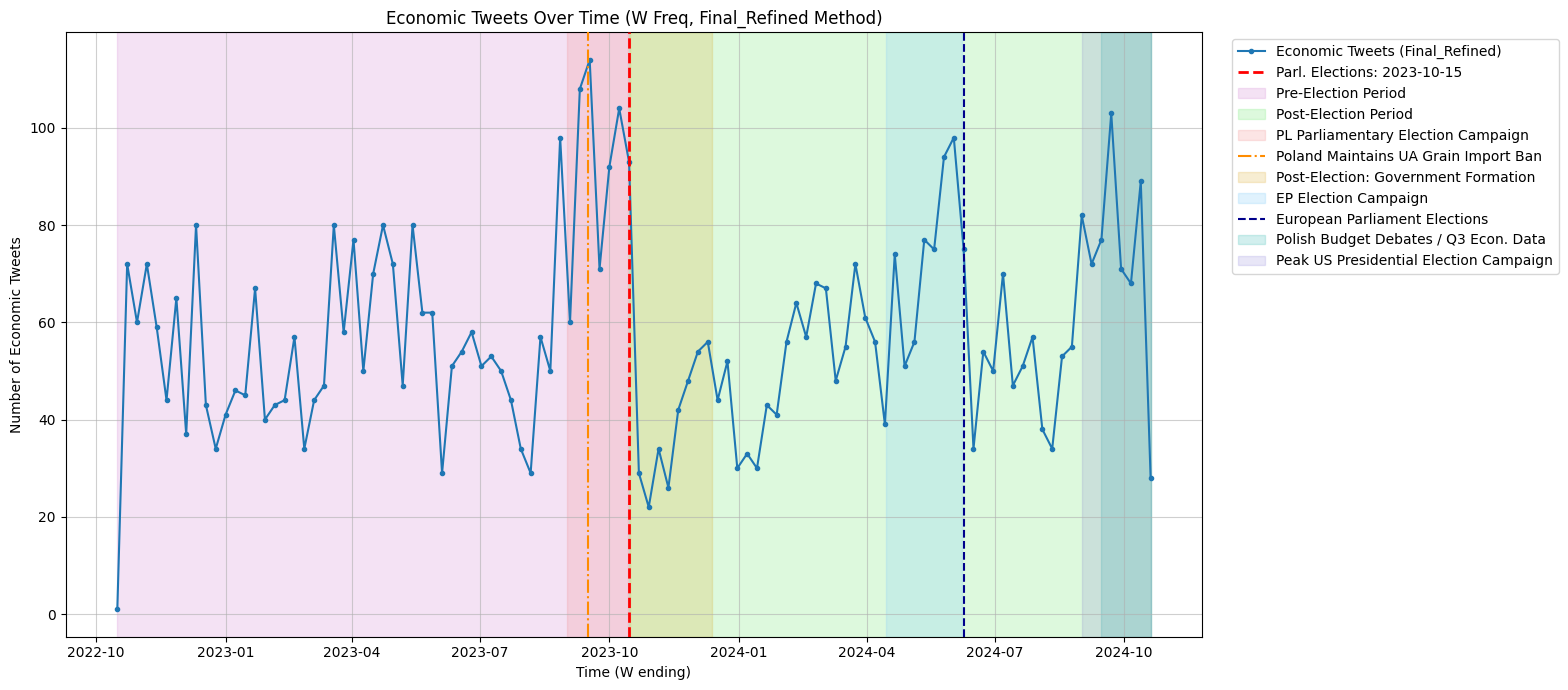


--- Time Series Analysis Section Complete ---
--------------------------------------------------


In [51]:
# --- Determine columns based on chosen method ---
flag_col = None; token_col_ts = None
if method_to_analyze == 'Union': flag_col = 'union_flag'; token_col_ts = 'union_tokens'
elif method_to_analyze == 'Gateway': flag_col = 'gateway_flag'; token_col_ts = 'gateway_tokens'
elif method_to_analyze == 'Final_Refined': flag_col = 'has_econ_term_FILTERED'; token_col_ts = 'matched_keywords_FILTERED'
else: print(f"ERROR: Unknown method '{method_to_analyze}'.")

# --- Generate Annotated Plot for Tweet Counts - HERE ---
if 'plot_annotated_timeseries' in locals() and flag_col and flag_col in df_clean_translated.columns:
    if date_col_ts not in df_clean_translated.columns: print(f"ERROR: Date column '{date_col_ts}' not found.")
    else:
         plot_annotated_timeseries(
             df=df_clean_translated, flag_col=flag_col, method_name=method_to_analyze,
             annotations=annotations_list, show_custom_annotations=show_other_custom_annotations,
             election_date_str=main_election_date_str, show_election_shading=show_pre_post_main_election_shading,
             freq=time_series_freq, date_col=date_col_ts, figsize=(18, 7))
elif not ('plot_annotated_timeseries' in locals()): print("ERROR: 'plot_annotated_timeseries' function not defined.")
else: print(f"Skipping annotated plot: Flag column '{flag_col}' missing or method invalid.")

# # --- Optional: Generate Top Token Plot ---
# print("\n--- Optional: Plotting Top Token Trends ---")
# if 'plot_top_token_timeseries' in locals() and token_col_ts and token_col_ts in df_clean_translated.columns:
#     if date_col_ts not in df_clean_translated.columns: print(f"ERROR: Date column '{date_col_ts}' not found.")
#     else:
#          plot_top_token_timeseries(
#               df=df_clean_translated, token_col=token_col_ts, method_name=method_to_analyze,
#               top_n=10, freq=time_series_freq, date_col=date_col_ts,
#               annotations=annotations_list, show_custom_annotations=show_other_custom_annotations,
#               election_date_str=main_election_date_str, show_election_shading=show_pre_post_main_election_shading)
# # ... (error messages for missing function or columns)

print("\n--- Time Series Analysis Section Complete ---")
print("-" * 50)

Example of usage of function 


Generating top 10 token time series plot for: Final_Refined Method
Custom annotations: SHOWN.
Election shading: SHOWN.
Top 10 tokens for Final_Refined: ['fund', 'energy', 'budget', 'taxes', 'investment', 'market', 'development', 'entrepreneurs', 'economy', 'finance']
Processing custom annotations for top token plot...


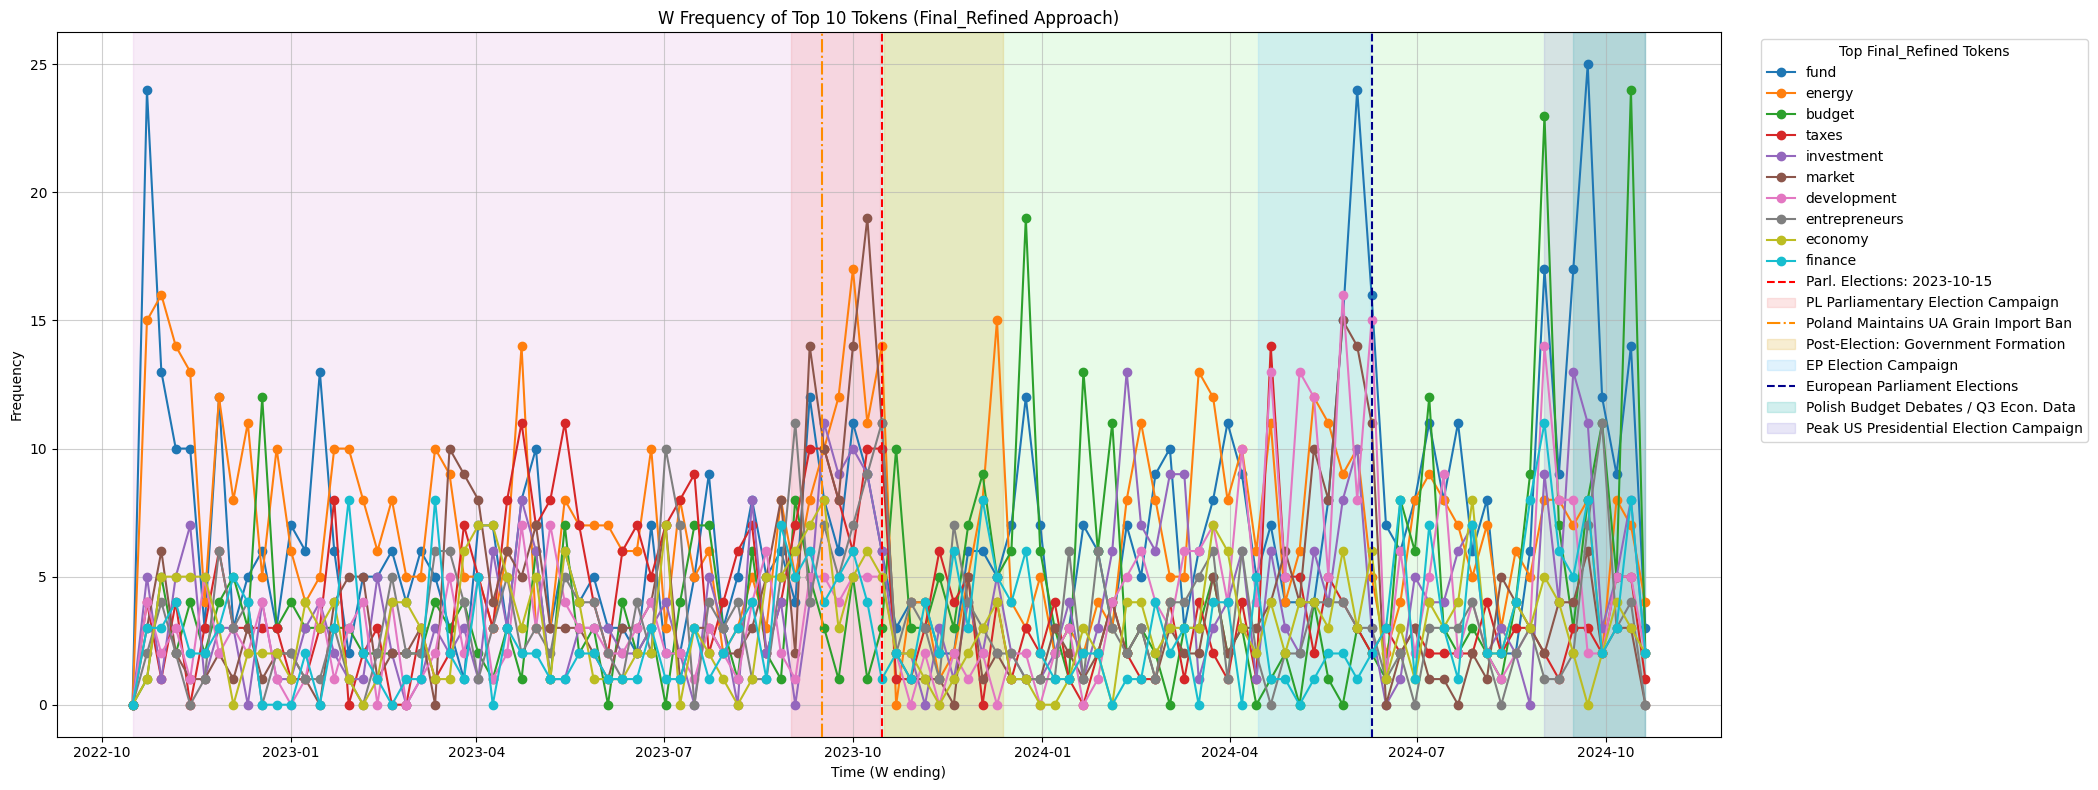

In [52]:
if 'plot_top_token_timeseries' in locals() and token_col_ts and token_col_ts in df_clean_translated.columns:
    if date_col_ts not in df_clean_translated.columns: print(f"ERROR: Date column '{date_col_ts}' not found.")
    else:
         plot_top_token_timeseries(
            df=df_clean_translated, 
            token_col=token_col_ts, 
            method_name=method_to_analyze,
            top_n=10, freq=time_series_freq, 
            date_col=date_col_ts,
            annotations=annotations_list, 
            show_custom_annotations=show_other_custom_annotations,
            election_date_str=main_election_date_str, 
            show_election_shading=show_pre_post_main_election_shading,
            figsize=(24, 8))


Generating annotated COUNT time series for: Final_Refined Method
Custom annotations: SHOWN.
Election shading: SHOWN.
Processing custom annotations for count plot...


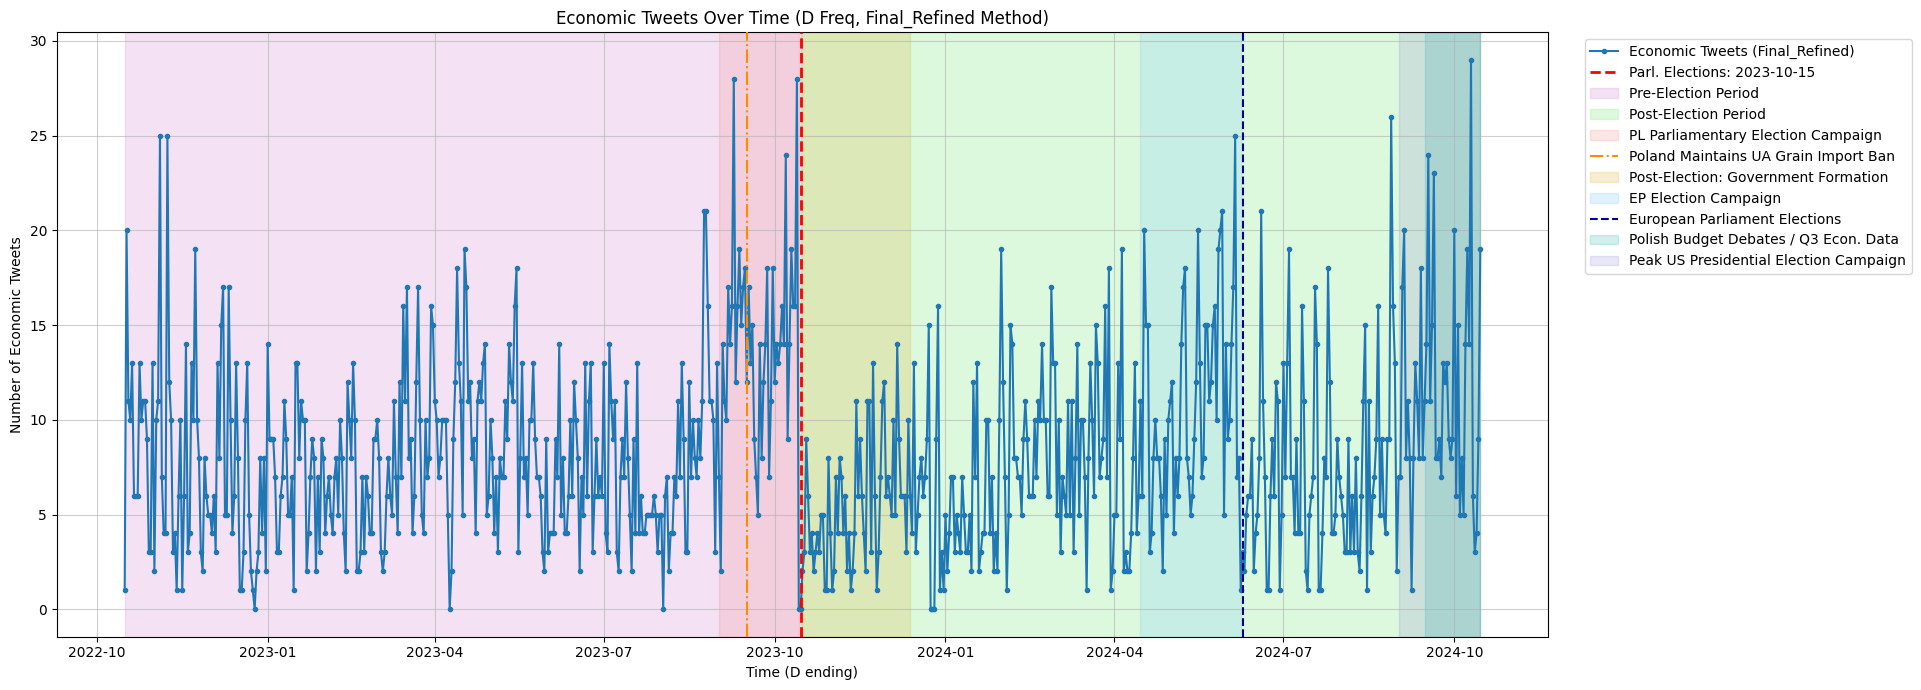

In [53]:
# --- Generate Annotated Plot for Tweet Counts ---
if 'plot_annotated_timeseries' in locals() and flag_col and flag_col in df_clean_translated.columns:
    if date_col_ts not in df_clean_translated.columns: print(f"ERROR: Date column '{date_col_ts}' not found.")
    else:
         plot_annotated_timeseries(
             df=df_clean_translated, 
             flag_col=flag_col, 
             method_name=method_to_analyze,
             annotations=annotations_list, 
             show_custom_annotations=show_other_custom_annotations,
             election_date_str=main_election_date_str, 
             show_election_shading=show_pre_post_main_election_shading,
             freq="D", 
             date_col=date_col_ts,
             figsize=(22, 7) # Optional: Adjust size for daily frequency
             )
elif not ('plot_annotated_timeseries' in locals()): print("ERROR: 'plot_annotated_timeseries' function not defined.")
else: print(f"Skipping annotated plot: Flag column '{flag_col}' missing or method invalid.")


Smoothed plots analysis


--- 10.C: Time Series Peak Analysis ---
Analyzing peaks for method: 'Final_Refined' using flag 'has_econ_term_FILTERED'
Applying a 12-period (W) rolling average...

Peak analysis (smoothed data): Max smoothed val: 75.83
  Periods with smoothed values >= 68.25 (90% of max):


created_at
2023-09-03    71.750000
2023-09-10    75.833333
2023-09-17    75.416667
2023-09-24    74.833333
2023-10-01    72.916667
2023-10-08    70.916667
2024-05-05    69.000000
2024-09-29    69.800000
2024-10-06    71.666667
2024-10-13    73.750000
2024-10-20    72.571429
Name: has_econ_term_FILTERED, dtype: float64

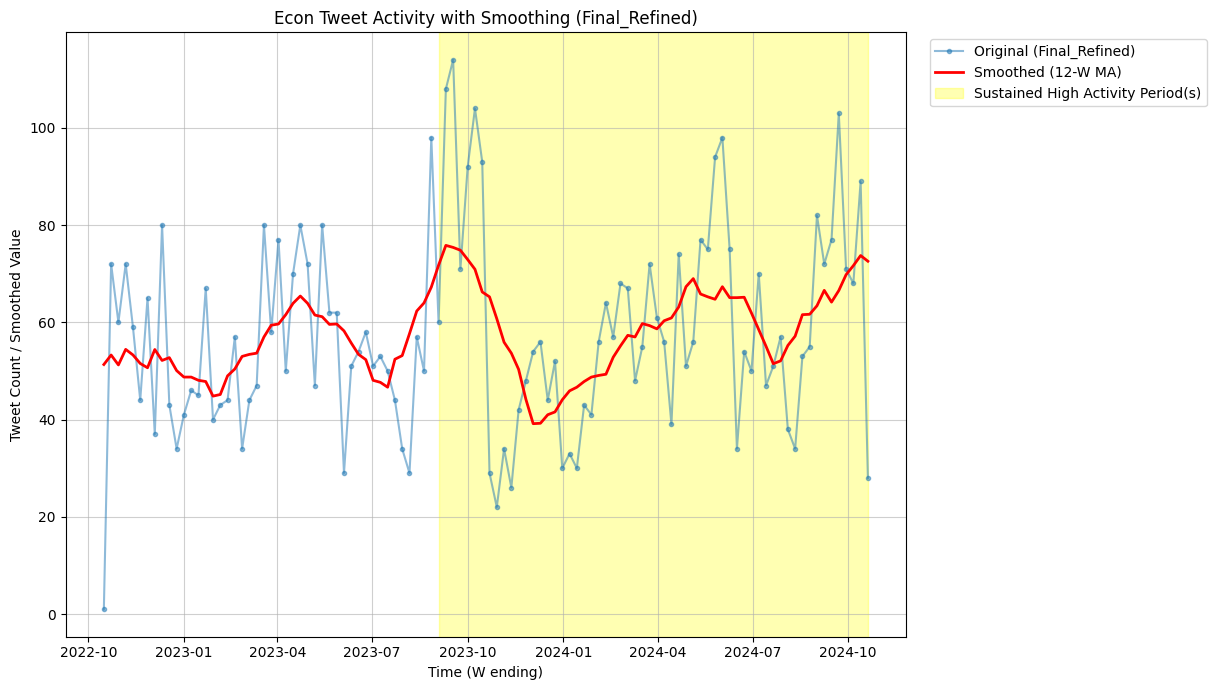


--- Time Series Peak Analysis Complete ---
--------------------------------------------------


In [56]:
# ==============================================================================
# SECTION 10.C: TIME SERIES PEAK ANALYSIS
# ==============================================================================

print("\n" + "="*60)
print("--- 10.C: Time Series Peak Analysis ---")
print("="*60)

run_peak_analysis = False
if 'df_clean_translated' not in globals() or df_clean_translated.empty:
    print("ERROR: 'df_clean_translated' DataFrame not found. Skipping peak analysis.")
elif flag_col is None or flag_col not in df_clean_translated.columns:
    print(f"ERROR: Flag column for method '{method_to_analyze}' ('{flag_col}') not defined or not found. Skipping peak analysis.")
elif date_col_ts not in df_clean_translated.columns:
    print(f"ERROR: Date column '{date_col_ts}' not found. Skipping peak analysis.")
else:
    print(f"Analyzing peaks for method: '{method_to_analyze}' using flag '{flag_col}'")
    df_peak_analysis = df_clean_translated.copy()
    try:
        df_peak_analysis[date_col_ts] = pd.to_datetime(df_peak_analysis[date_col_ts], errors='coerce')
        df_peak_analysis.dropna(subset=[date_col_ts], inplace=True)
        if not df_peak_analysis.empty:
            df_peak_analysis = df_peak_analysis.set_index(date_col_ts).sort_index() # Set index, no drop=False
            if df_peak_analysis.index.tz is not None:
                df_peak_analysis.index = df_peak_analysis.index.tz_convert('UTC').tz_localize(None)
            ts_counts_for_peaks = df_peak_analysis[flag_col].resample(time_series_freq).sum()
            if not ts_counts_for_peaks.empty: run_peak_analysis = True
            else: print("No data after resampling for peak analysis.")
        else: print("No valid date data for peak analysis.")
    except Exception as e: print(f"Error preparing data for peak analysis: {e}")

if run_peak_analysis:
    # --- Smoothing and Peak Detection ---
    if time_series_freq == 'W': smoothing_window = 12
    elif time_series_freq == 'M': smoothing_window = 3
    elif time_series_freq == 'D': smoothing_window = 90
    else: smoothing_window = 12; print(f"Warning: Using default smoothing window for freq '{time_series_freq}'")
    print(f"Applying a {smoothing_window}-period ({time_series_freq}) rolling average...")
    ts_smoothed = ts_counts_for_peaks.rolling(window=smoothing_window, center=True, min_periods=smoothing_window//2).mean().dropna()
    if ts_smoothed.empty: print("Smoothed time series empty.")
    else:
        max_smoothed_value = ts_smoothed.max(); peak_threshold = max_smoothed_value * 0.90
        peak_periods_smoothed = ts_smoothed[ts_smoothed >= peak_threshold]
        print(f"\nPeak analysis (smoothed data): Max smoothed val: {max_smoothed_value:.2f}")
        print(f"  Periods with smoothed values >= {peak_threshold:.2f} (90% of max):")
        if not peak_periods_smoothed.empty:
            try: display(peak_periods_smoothed)
            except NameError: print(peak_periods_smoothed.to_string())
            # --- Visualization of Smoothed Data and Peaks ---
            fig, ax = plt.subplots(figsize=(14, 7))
            ax.plot(ts_counts_for_peaks.index, ts_counts_for_peaks.values, marker='.', linestyle='-', label=f'Original ({method_to_analyze})', alpha=0.5, zorder=5)
            ax.plot(ts_smoothed.index, ts_smoothed.values, linestyle='-', label=f'Smoothed ({smoothing_window}-{time_series_freq} MA)', color='red', lw=2, zorder=10)
            if not peak_periods_smoothed.empty:
                peak_start = peak_periods_smoothed.index.min(); peak_end = peak_periods_smoothed.index.max()
                ax.axvspan(peak_start, peak_end, color='yellow', alpha=0.3, label='Sustained High Activity Period(s)', zorder=1)
            ax.set_title(f'Econ Tweet Activity with Smoothing ({method_to_analyze})'); ax.set_xlabel(f'Time ({time_series_freq} ending)'); ax.set_ylabel('Tweet Count / Smoothed Value')
            ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1)); ax.grid(True, alpha=0.6); plt.tight_layout(rect=[0, 0, 0.88, 1]); plt.show()
        else: print("  No significant peak periods identified in smoothed data.")
else: print("Skipping peak analysis due to earlier errors or no data.")
print("\n--- Time Series Peak Analysis Complete ---")
print("-" * 50)

In [ ]:
party_colors = {
    'Konfederacja': 'red',
    'NL': 'blue',    
    'PL2050': 'green',
    'PO': 'purple',  
    'PSL': 'orange',
    'PIS': 'yellow',  
    'Unknown_Party': 'grey'
}

#### 3. Rank plots 

Plots codes done, sentiment analysis will be done in the [009c.EconomicWords_sentiment.ipynb](009c.EconomicWords_sentiment.ipynb)